## **Project: Decoding Speech from Inexpensive, Non-Invasive Brain Signals**

README:
 - **installs and imports** (just run the cell)
 - **working directory** (just run the cell)
 - **configs** (just run the cell, feel free to change the configs if needed)
 - **datasets and dataloaders** (just run the cells, it will load and return raw eeg and already embedded audio. the audio was embedded using a pre-trained Wav2Vec2 model)
 - **models**
   - **replicated meta models** (feel free to use any of the blocks or create your own model)
   - **brain encoder** (just run, it's a simpler new model)
   - **brain-audio model** (just run, it takes in raw eeg data from the dataloader, creates embedding using the above-mentioned brain encoder, and then passses it through a linear layer to align the shapes with the audio. as a result the embedded eeg will have a shape [batch size, timesteps, number of features] and the number of features should be 1024 to align it with the embeeded audio)
   - **audio-word decoder & wer metrics** (it decodes embedded eeg and audio into actual word sequences and then calculates a set of metrics that we will use during validation: Levenshtein-based WER, WER General, Accuracy General, WER Vocabulary, and Accuracy Vocabulary)
 - **training and validation**
   - **clip loss** (just run the cell, this is a Meta's version of OpenAI CLIP loss but slightly adapted to eeg-to-audio instead of images-to-words tasks. be careful, this version of CLIP loss expects the eeg and audio embeddings to be of the same shape - [batch size, number of features, timesteps]. number of features will be automatically the same based on the model output but we use padding to match the timesteps between audio and eeg embeddings)
   - **utils** (just run the cell, it contains useful functions for plotting the attention, loading, saving the model as well as doing a kaiming weight initialization)
   - **training and validation functions**
     - **training function** (just run, it takes the eeg embeddings from our model and audio embedings from the dataloader, then transforms them to match the expected format of the CLIP loss, then uses the CLIP loss to optimize, and finally outputs the training loss)
     - **validation function** (just run, it's similar to the training function but in addition it calculates the evaluation metrics discussed previously)
   - **experiment set up** (just run, feel free to change the configs if needed)
   - **wandb** (just add your key, and it should automatically log the experiment to your wandb's directory)
   - **running the experiment** (just run the cell, feel free to change the configs if needed. it has code to automatically save and load the checkpoints)

# **installs and imports**

In [ ]:
!pip install wandb torchsummaryX mne transformers Levenshtein adamp jiwer -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.0/254.0 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
### Torch
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
from    torch.optim import lr_scheduler
from    torchsummaryX import summary
from    torch.utils.data import Dataset, DataLoader, random_split
import  torchaudio
import  torchaudio.transforms as tat
from    torch.nn.utils.rnn import (pad_sequence, pack_padded_sequence,
                                   pad_packed_sequence)
from torch.optim import AdamW
from adamp import AdamP

### General
import  random
import  numpy as np
import  pandas as pd
import  scipy
import  gc
from    tqdm.auto import tqdm
import  os
import  datetime
import  time
import  wandb
import  matplotlib.pyplot as plt
import  seaborn as sns
import re
import seaborn
import Levenshtein as lev
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import gc
from tqdm import tqdm
from collections import defaultdict
from collections import Counter
import scipy.stats as stats
from sklearn.preprocessing import RobustScaler

### Other

from functools import partial
import logging
import math
import typing as tp
import warnings
warnings.filterwarnings('ignore')

#import torch.multiprocessing as mp
#mp.set_start_method('spawn', force=True)

# wav2vec2 and EEG processing
from    transformers import (AutoProcessor, AutoModelForPreTraining,
                             CLIPProcessor, CLIPModel, Wav2Vec2ForCTC, Wav2Vec2Processor)
import  mne
from transformers import Wav2Vec2Model

pd.set_option('display.max_columns', 80)

# **working directory**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_PATH  = '/content/gdrive/MyDrive/11785-IDLf23/Final_project/0_Data/'

BRAIN_PATH = os.path.join(DATA_PATH, 'brennan_and_hale_v2')
AUDIO_PATH = os.path.join(DATA_PATH, 'brennan_and_hale_v2/audio')
PPROC_PATH = os.path.join(DATA_PATH, 'brennan_and_hale_v2/proc/timelock-preprocessing')

EEG_PATH   = os.path.join(DATA_PATH, 'eeg-segments')
EMBED_PATH = os.path.join(DATA_PATH, 'brennan_wav2vec2_embeddings')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **configs**

In [ ]:
config = dict(

    # dataloaders ----------------------------------------------------------------
    batch_size = 10, # recs, please use: 8 to 16
    transforms = None,
    reduce_data_ratio = 1, # 1 if we want to use the entire dataset

    # model ----------------------------------------------------------------

    ###

    ###

    ###

    # optimizer ----------------------------------------------------------------
    learning_rate = 0.00001,
    weight_decay = 5e-3,

    # scheduler ----------------------------------------------------------------
    factor = 0.9,
    patience = 3,

    # trainer ----------------------------------------------------------------
    epochs = 50)

# **dataset and dataloaders**

In [ ]:
# Load audio embeddings
AUDIO_EMBEDDINGS = {}
embed_fnames = sorted(os.listdir(EMBED_PATH))
for segment_idx, fname in enumerate(tqdm(embed_fnames), start=1):
    audio_fpath = os.path.join(EMBED_PATH, fname)
    audio = torch.load(audio_fpath)
    audio_embed = audio.hidden_states[-1]
    audio_embed = audio_embed.squeeze(0)
    AUDIO_EMBEDDINGS[segment_idx] = audio_embed
    del audio, audio_embed
    gc.collect()

100%|██████████| 12/12 [00:54<00:00,  4.54s/it]


## dataset class

In [ ]:
class BrainAudioDataset(torch.utils.data.Dataset): # UPDATED (3s segments)
    """
    Hybrid Memory Efficient Dataset.
    Loads all audio embeddings in __init__(). ~1-2min.
    Loads eeg in __getitem__().
    Loading everything in __init__() crashes.
    Loading everything in __getitem__() is super slow.

    Load eeg
    Pad (add AUD of zeros) to be 62 chan
    Mask the bad chans
    """

    def __init__(self,
                 eeg_fnames,
                 eeg_path=EEG_PATH,
                 audio_embeddings=AUDIO_EMBEDDINGS,
                 test=False,
                 transforms=None):
        super().__init__()

        self.test = test
        self.eeg_root = eeg_path
        self.transforms = transforms

        # Get pre-saved audio embeddings (dict indexed 1, ..., 12)
        self.audio_embeddings = audio_embeddings

        # EEG (pre-defined train/val/test set of eeg)
        gc.collect()
        self.eegs = {}
        for idx, fname in enumerate(tqdm(eeg_fnames)):
            # Extract subject id and segment (to be returned in __getitem__())
            subject_idx, segment_idx = self.extract_info(fname)

            # Load eeg filepath
            eeg_fpath = os.path.join(self.eeg_root, fname)
            self.eegs[idx] = (subject_idx, int(segment_idx), eeg_fpath)

        self.length = len(self.eegs)

        # montage = mne.channels.make_standard_montage("easycap-M10")

    def __len__(self):

        return self.length

    def __getitem__(self, idx):
        """
        - eeg           : (1, T_eeg, C_eeg)
        - audio_embed   : (1, T_audio, 1024)
        """
        # Get eeg
        _, segment_idx, eeg_fpath = self.eegs[idx]
        eeg = np.load(eeg_fpath)

        # Apply baseline correction
        baseline = np.mean(eeg[:, :int(0.5 * 120)], axis=1)
        eeg -= baseline[:, None]

        # Robust scaling using scikit-learn
        scaler = RobustScaler()
        eeg = scaler.fit_transform(eeg.T).T

        # Clipping the outliers below 5th percentile and above 95th percentile
        eeg = np.clip(eeg, np.percentile(eeg, 5), np.percentile(eeg, 95))

        # Clamping values greater than 20 standard deviations
        std = np.std(eeg)
        mean = np.mean(eeg)
        eeg = np.clip(eeg, mean - 20 * std, mean + 20 * std)

        # Standard normalization for EEG
        eeg_mean = eeg.mean()
        eeg_std = eeg.std()
        eeg = (eeg - eeg_mean) / eeg_std

        # Convert to torch tensor and select a 3-second window
        eeg = torch.tensor(eeg[:, :3 * 120].transpose())

        # Retrieve pre-loaded audio embedding
        audio_embed = self.audio_embeddings[segment_idx][:3 * 50]

        # Standard normalization for audio
        audio_mean = audio_embed.mean()
        audio_std = audio_embed.std()
        audio_embed = (audio_embed - audio_mean) / audio_std

        return eeg, audio_embed, len(eeg), len(audio_embed)

    def collate_fn(self, batch):

        eeg, audio_embed, len_eeg, len_audio_embed = zip(*batch)

        # (Optional) Clipping each EEG in the batch
        """
        eeg_clipped = []
        for eeg_sample in eeg:
            lower_bound = torch.quantile(eeg_sample, 0.05)
            upper_bound = torch.quantile(eeg_sample, 0.95)
            eeg_clipped.append(torch.clamp(eeg_sample, lower_bound, upper_bound))
        """

        # pad sequences
        batch_eeg_pad = pad_sequence(eeg, batch_first=True)
        batch_audio_embed_pad = pad_sequence(audio_embed, batch_first=True)
        del eeg, audio_embed

        # Apply transformations
        if self.transforms is not None:
            batch_eeg_pad = self.transforms(batch_eeg_pad)

        if self.test:
            return (
                batch_eeg_pad,
                torch.tensor(len_eeg, dtype=torch.int64)
            )
        else:
            return (
                batch_eeg_pad,
                batch_audio_embed_pad,
                torch.tensor(len_eeg, dtype=torch.int64),
                torch.tensor(len_audio_embed, dtype=torch.int64)
            )

    def read_sfp(self, file_path=os.path.join(BRAIN_PATH, 'easycapM10-acti61_elec.sfp')):
        """
        Reads a BESA SFP (Surface Point) file (locations of sensors)
        """

        electrodes = {}
        with open(file_path, 'r') as file:
            for line in file:
                parts = line.strip().split()  # Split by whitespace
                if len(parts) == 4:
                    # Parse the electrode name and coordinates
                    name = parts[0]
                    x, y, z = map(float, parts[1:])  # Convert strings to floats
                    electrodes[name] = (x, y, z)

        return electrodes

    def extract_info(self, fname):
        # This pattern looks for any text (non-digits) followed by digits, a hyphen, and more digits
        match = re.match(r'([A-Za-z]+[0-9]+)-([0-9]+).npy', fname)
        if match:
            return match.group(1), match.group(2)
        else:
            return None

## train/val/test split

In [ ]:
eeg_paths = sorted(os.listdir(EEG_PATH))
num_eeg = len(eeg_paths)

print(f"Len of full dataset: {num_eeg}")

TRAIN_TEST_SPLIT = 0.8
VAL_TEST_SPLIT   = 0.5

random.seed(1)
eeg_paths_shuffled = random.shuffle(eeg_paths)

#-------------------------------------------------------------------------------

print(f"Splitting into 80/10/10...")

train_idx = int(num_eeg * TRAIN_TEST_SPLIT)
val_idx =   train_idx + int((num_eeg - train_idx) * VAL_TEST_SPLIT)

train_set = eeg_paths[:train_idx]
val_set   = eeg_paths[train_idx:val_idx]
test_set  = eeg_paths[val_idx:]

print("Shapes:")
print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")
print('-'*80)
print('Sets:')
print(f'Train: {train_set}')
print(f'Val:   {val_set}')
print(f'Test:  {test_set}')

#-------------------------------------------------------------------------------
# Convert lists to sets for easier operations
train_set_set = set(train_set)
val_set_set   = set(val_set)
test_set      = set(test_set)

# Check for intersections
intersection1 = train_set_set.intersection(val_set_set)
intersection2 = train_set_set.intersection(test_set)
intersection3 = val_set_set.intersection(test_set)

# Check that intersections are empty (no overlap)
no_overlap = len(intersection1) == 0 and len(intersection2) == 0 and len(intersection3) == 0

# Verify the total count
correct_total_count = len(train_set) + len(val_set) + len(test_set)

assert no_overlap
assert correct_total_count == num_eeg

Len of full dataset: 348
Splitting into 80/10/10...
Shapes:
Train: 278, Val: 35, Test: 35
--------------------------------------------------------------------------------
Sets:
Train: ['S42-12.npy', 'S39-8.npy', 'S11-3.npy', 'S45-2.npy', 'S45-6.npy', 'S45-5.npy', 'S41-4.npy', 'S25-6.npy', 'S20-9.npy', 'S16-11.npy', 'S10-3.npy', 'S14-3.npy', 'S48-3.npy', 'S15-8.npy', 'S37-5.npy', 'S39-12.npy', 'S22-9.npy', 'S06-11.npy', 'S41-10.npy', 'S04-4.npy', 'S17-9.npy', 'S18-9.npy', 'S03-5.npy', 'S19-8.npy', 'S41-1.npy', 'S37-11.npy', 'S06-9.npy', 'S19-11.npy', 'S40-2.npy', 'S17-2.npy', 'S45-3.npy', 'S11-8.npy', 'S25-3.npy', 'S41-3.npy', 'S17-8.npy', 'S04-9.npy', 'S37-12.npy', 'S04-5.npy', 'S19-2.npy', 'S48-5.npy', 'S18-10.npy', 'S21-9.npy', 'S08-8.npy', 'S18-7.npy', 'S25-4.npy', 'S20-8.npy', 'S18-12.npy', 'S18-5.npy', 'S13-12.npy', 'S12-2.npy', 'S44-10.npy', 'S17-5.npy', 'S41-7.npy', 'S18-4.npy', 'S01-8.npy', 'S20-2.npy', 'S22-2.npy', 'S20-4.npy', 'S37-2.npy', 'S12-5.npy', 'S15-10.npy', 'S08-5.np

## datasets

In [ ]:
train_dataset = BrainAudioDataset(
    eeg_fnames = train_set,
    eeg_path = EEG_PATH,
    audio_embeddings=AUDIO_EMBEDDINGS,
    test = False,
    transforms = None
)

val_dataset = BrainAudioDataset(
    eeg_fnames = val_set,
    eeg_path = EEG_PATH,
    audio_embeddings=AUDIO_EMBEDDINGS,
    test = False,
    transforms = None
)

test_dataset = BrainAudioDataset(
    eeg_fnames = test_set,
    eeg_path = EEG_PATH,
    audio_embeddings=AUDIO_EMBEDDINGS,
    test = True,
    transforms = None
)

100%|██████████| 35/35 [00:00<00:00, 123882.40it/s]


## dataloader definition

In [ ]:
import os
os.cpu_count()

8

In [ ]:
# Train Loader------------------------------------------------------------------
train_loader = torch.utils.data.DataLoader(
    dataset      = train_dataset,
    batch_size   = config['batch_size'],
    shuffle      = True,
    drop_last    = False,
    num_workers  = 8,
    pin_memory   = True,
    collate_fn   = train_dataset.collate_fn,
)

# Val Loader--------------------------------------------------------------------
val_loader = torch.utils.data.DataLoader(
    dataset      = val_dataset,
    batch_size   = config['batch_size'],
    shuffle      = False,
    drop_last    = False,
    num_workers  = 4,
    pin_memory   = True,
    collate_fn   = val_dataset.collate_fn
)

# Test Loader-------------------------------------------------------------------
test_loader = torch.utils.data.DataLoader(
    dataset      = test_dataset,
    batch_size   = config['batch_size'],
    shuffle      = False,
    drop_last    = False,
    num_workers  = 4,
    pin_memory   = True,
    collate_fn   = test_dataset.collate_fn
)

In [ ]:
print('-'*80)
# print(f'Len full data:      {len(full_dataset)}')
print(f'Len train data:     {len(train_dataset)}')
print(f'Len val data:       {len(val_dataset)}')
print(f'Len test data:      {len(test_dataset)}')
print('-'*80)
print(f'Len Train Loader:   {train_loader.__len__()}')
print(f'Len Val Loader:     {val_loader.__len__()}')
print(f'Len Test Loader:    {test_loader.__len__()}')

gc.collect()

for batch in train_loader:
    eeg, audio_embedding, l_eeg, l_audio = batch
    print(eeg.shape, audio_embedding.shape, l_eeg.shape, l_audio.shape)
    print(eeg.dtype, audio_embedding.dtype, l_eeg.dtype, l_audio.dtype)
    del eeg, audio_embedding, l_eeg, l_audio
    gc.collect()
    break

for batch in val_loader:
    eeg, audio_embedding, l_eeg, l_audio = batch
    print(eeg.shape, audio_embedding.shape, l_eeg.shape, l_audio.shape)
    print(eeg.dtype, audio_embedding.dtype, l_eeg.dtype, l_audio.dtype)
    del eeg, audio_embedding, l_eeg, l_audio
    gc.collect()
    break

for batch in test_loader:
    eeg, l_eeg = batch
    print(eeg.shape, l_eeg.shape)
    print(eeg.dtype, l_eeg.dtype)
    del eeg, l_eeg
    gc.collect()
    break

--------------------------------------------------------------------------------
Len train data:     278
Len val data:       35
Len test data:      35
--------------------------------------------------------------------------------
Len Train Loader:   28
Len Val Loader:     4
Len Test Loader:    4
torch.Size([10, 360, 62]) torch.Size([10, 150, 1024]) torch.Size([10]) torch.Size([10])
torch.float64 torch.float32 torch.int64 torch.int64
torch.Size([10, 360, 62]) torch.Size([10, 150, 1024]) torch.Size([10]) torch.Size([10])
torch.float64 torch.float32 torch.int64 torch.int64
torch.Size([10, 360, 62]) torch.Size([10])
torch.float64 torch.int64


In [ ]:
for eeg, audio_embedding, l_eeg, l_audio in train_loader:
    print(eeg.shape, audio_embedding.shape)
    break

# when full sequence I had --> torch.Size([8, 31656, 62]) torch.Size([8, 3313, 1024])
# when 3s --> torch.Size([8, 360, 62]) torch.Size([8, 150, 1024])

torch.Size([10, 360, 62]) torch.Size([10, 150, 1024])


## check if transforms worked

In [ ]:
# Check if clipping worked - before
"""
# Fetch a batch of data
for batch in train_loader:
    eeg, audio_embedding, l_eeg, l_audio = batch
    break

# Convert EEG data to numpy array for percentile calculations (if it's not already a numpy array)
eeg_numpy = eeg.numpy()

# Calculate the min and max values in the batch
batch_min = eeg_numpy.min()
batch_max = eeg_numpy.max()

# Print the min and max values
print(f"Minimum value in the batch: {batch_min}")
print(f"Maximum value in the batch: {batch_max}")
"""

Minimum value in the batch: -1.1433482499999998
Maximum value in the batch: 2.5094315


In [ ]:
# Check if clipping worked - after
"""
# Fetch a batch of data
for batch in train_loader:
    eeg, audio_embedding, l_eeg, l_audio = batch
    break

# Convert EEG data to numpy array for percentile calculations (if it's not already a numpy array)
eeg_numpy = eeg.numpy()

# Calculate the min and max values in the batch
batch_min = eeg_numpy.min()
batch_max = eeg_numpy.max()

# Print the min and max values
print(f"Minimum value in the batch: {batch_min}")
print(f"Maximum value in the batch: {batch_max}")
"""

Minimum value in the batch: -0.058208657226562495
Maximum value in the batch: 0.03224046142578124


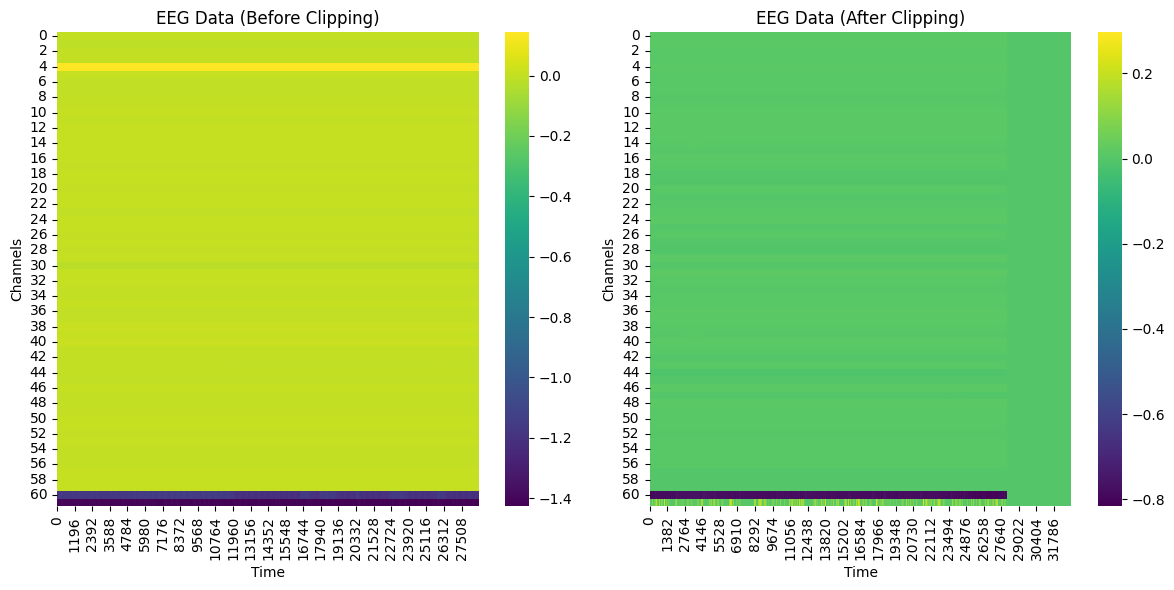

In [ ]:
# BATCH/COLLATE EEG

# Fetch one batch of data
for batch in train_loader:
    eeg, _, _, _ = batch
    break  # We only need one batch for demonstration

# Select a segment to plot (e.g., segment 0)
segment_idx = 1

# EEG data before clipping (directly from file)
_, _, eeg_fpath = train_dataset.eegs[segment_idx]
eeg_data = np.load(eeg_fpath)  # shape [n_channels (62), timesteps]

# EEG data after clipping (from DataLoader)
eeg_data_clipped = eeg[segment_idx].numpy().transpose()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before clipping
sns.heatmap(eeg_data, cmap='viridis', ax=axes[0])
axes[0].set_title('EEG Data (Before Clipping)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Channels')

# After clipping
sns.heatmap(eeg_data_clipped, cmap='viridis', ax=axes[1])
axes[1].set_title('EEG Data (After Clipping)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Channels')

plt.tight_layout()
plt.show()


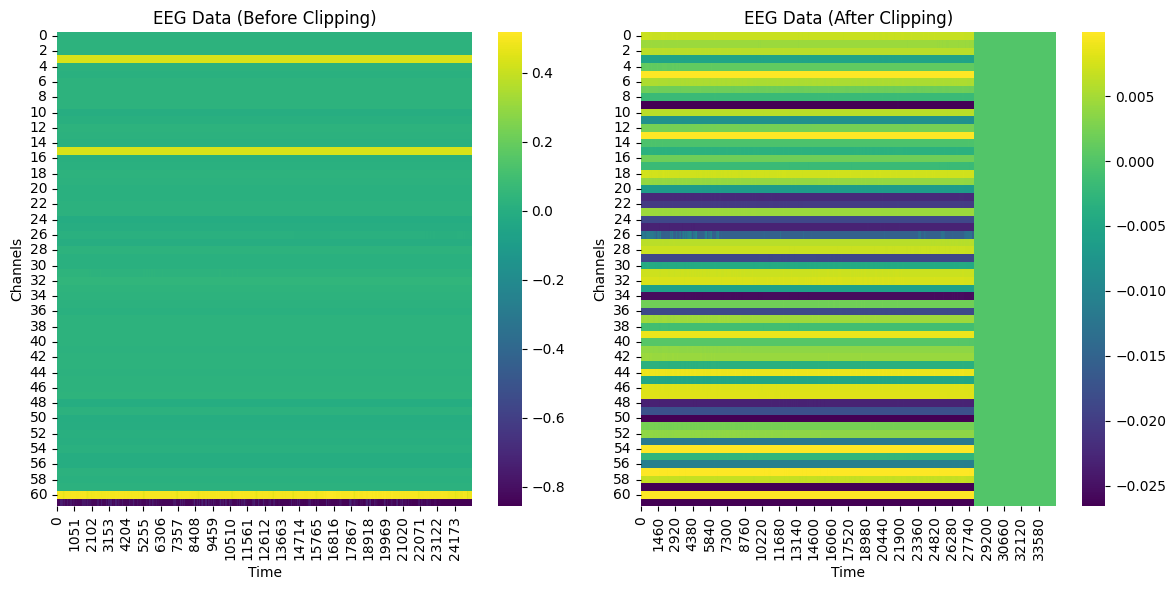

In [ ]:
# ITEM/GETITEM EEG

# Fetch one batch of data
for batch in train_loader:
    eeg, _, _, _ = batch
    break  # We only need one batch for demonstration

# Select a segment to plot (e.g., segment 0)
segment_idx = 0

# EEG data before clipping (directly from file)
_, _, eeg_fpath = train_dataset.eegs[segment_idx]
eeg_data = np.load(eeg_fpath)  # shape [n_channels (62), timesteps]

# EEG data after clipping (from DataLoader)
eeg_data_clipped = eeg[segment_idx].numpy().transpose()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before clipping
sns.heatmap(eeg_data, cmap='viridis', ax=axes[0])
axes[0].set_title('EEG Data (Before Clipping)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Channels')

# After clipping
sns.heatmap(eeg_data_clipped, cmap='viridis', ax=axes[1])
axes[1].set_title('EEG Data (After Clipping)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Channels')

plt.tight_layout()
plt.show()


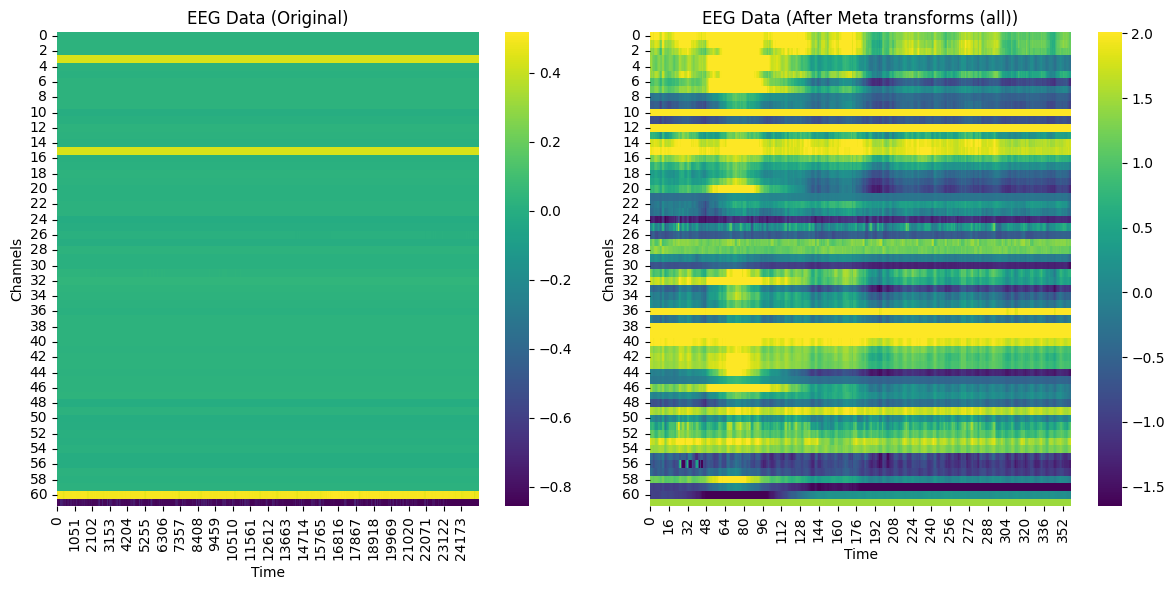

In [ ]:
# ITEM/GETITEM EEG

# Fetch one batch of data
for batch in train_loader:
    eeg, _, _, _ = batch
    break  # We only need one batch for demonstration

# Select a segment to plot (e.g., segment 0)
segment_idx = 0

# EEG data before clipping (directly from file)
_, _, eeg_fpath = train_dataset.eegs[segment_idx]
eeg_data = np.load(eeg_fpath)  # shape [n_channels (62), timesteps]

# EEG data after clipping (from DataLoader)
eeg_data_clipped = eeg[segment_idx].numpy().transpose()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before clipping
sns.heatmap(eeg_data, cmap='viridis', ax=axes[0])
axes[0].set_title('EEG Data (Original)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Channels')

# After clipping
sns.heatmap(eeg_data_clipped, cmap='viridis', ax=axes[1])
axes[1].set_title('EEG Data (After Meta transforms (all))')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Channels')

plt.tight_layout()
plt.show()


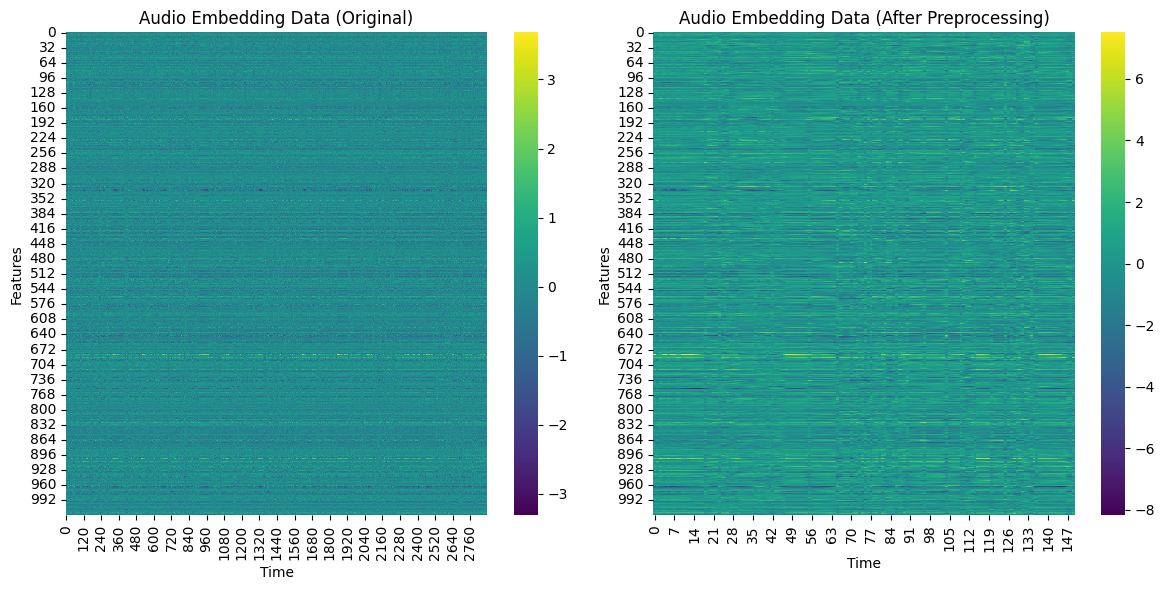

In [ ]:
# ITEM/GETITEM AUDIO

# Fetch one batch of data
for batch in train_loader:
    eeg, audio_embed, _, _ = batch
    break  # We only need one batch for demonstration

# Select a segment to plot (e.g., segment 0)
segment_idx = 0

# Audio data before preprocessing (directly from file)
audio_data_original = AUDIO_EMBEDDINGS[segment_idx + 1].numpy().T  # +1 if segment_idx is 0-indexed

# Audio data after preprocessing (from DataLoader)
audio_data_preprocessed = audio_embed[segment_idx].numpy().T

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before preprocessing
sns.heatmap(audio_data_original, cmap='viridis', ax=axes[0])
axes[0].set_title('Audio Embedding Data (Original)')
axes[0].set_xlabel('Time')  # Adjust label as appropriate
axes[0].set_ylabel('Features')  # Adjust label as appropriate

# After preprocessing
sns.heatmap(audio_data_preprocessed, cmap='viridis', ax=axes[1])
axes[1].set_title('Audio Embedding Data (After Preprocessing)')
axes[1].set_xlabel('Time')  # Adjust label as appropriate
axes[1].set_ylabel('Features')  # Adjust label as appropriate

plt.tight_layout()
plt.show()

# **eda**

In [ ]:
# Stats per subject and segment

# Extract subject IDs from file names
subject_ids_train = [filename.split('-')[0] for filename in train_set]
subject_ids_val = [filename.split('-')[0] for filename in val_set]
subject_ids_test = [filename.split('-')[0] for filename in test_set]

# Count the occurrences of each subject
subject_count_train = Counter(subject_ids_train)
subject_count_val = Counter(subject_ids_val)
subject_count_test = Counter(subject_ids_test)

# Calculate the number of unique subjects across all sets
all_subject_ids = set(subject_ids_train + subject_ids_val + subject_ids_test)
num_unique_subjects = len(all_subject_ids)

# Display the number of unique subjects in each set
print('Total number of unique subjects across all sets:', num_unique_subjects)
print('Number of unique subjects in training set:', len(subject_count_train))
print('Number of unique subjects in validation set:', len(subject_count_val))
print('Number of unique subjects in test set:', len(subject_count_test))

# Number of segments per subject in each set
segments_per_subject_train = dict(subject_count_train)
segments_per_subject_val = dict(subject_count_val)
segments_per_subject_test = dict(subject_count_test)

# Combining the counters from train, validation, and test datasets
combined_segments_count = {}
for subject in all_subject_ids:
    combined_segments_count[subject] = {'train': subject_count_train.get(subject, 0),
                                        'val': subject_count_val.get(subject, 0),
                                        'test': subject_count_test.get(subject, 0)}
sorted_combined_segments_count = dict(sorted(combined_segments_count.items()))
print('Distribution:')
sorted_combined_segments_count

Total number of unique subjects across all sets: 29
Number of unique subjects in training set: 29
Number of unique subjects in validation set: 20
Number of unique subjects in test set: 20
Distribution:


{'S01': {'train': 9, 'val': 0, 'test': 3},
 'S03': {'train': 8, 'val': 1, 'test': 3},
 'S04': {'train': 11, 'val': 0, 'test': 1},
 'S05': {'train': 11, 'val': 1, 'test': 0},
 'S06': {'train': 9, 'val': 1, 'test': 2},
 'S08': {'train': 9, 'val': 1, 'test': 2},
 'S10': {'train': 12, 'val': 0, 'test': 0},
 'S11': {'train': 10, 'val': 2, 'test': 0},
 'S12': {'train': 10, 'val': 1, 'test': 1},
 'S13': {'train': 6, 'val': 3, 'test': 3},
 'S14': {'train': 10, 'val': 1, 'test': 1},
 'S15': {'train': 11, 'val': 0, 'test': 1},
 'S16': {'train': 8, 'val': 4, 'test': 0},
 'S17': {'train': 11, 'val': 0, 'test': 1},
 'S18': {'train': 10, 'val': 2, 'test': 0},
 'S19': {'train': 10, 'val': 2, 'test': 0},
 'S20': {'train': 8, 'val': 1, 'test': 3},
 'S21': {'train': 9, 'val': 3, 'test': 0},
 'S22': {'train': 9, 'val': 1, 'test': 2},
 'S25': {'train': 9, 'val': 1, 'test': 2},
 'S37': {'train': 9, 'val': 1, 'test': 2},
 'S38': {'train': 7, 'val': 4, 'test': 1},
 'S39': {'train': 11, 'val': 0, 'test': 1},


## spatial viz

In [ ]:
# Read electrode positions

electrode_positions = train_dataset.read_sfp()
electrode_positions

{'1': (0.0, 3.517, 8.285),
 '2': (3.045, 1.758, 8.285),
 '3': (3.045, -1.758, 8.285),
 '4': (0.0, -3.517, 8.285),
 '5': (-3.045, -1.758, 8.285),
 '6': (-3.045, 1.758, 8.285),
 '7': (0.0, 8.345, 3.371),
 '8': (3.394, 7.623, 3.371),
 '9': (6.201, 5.584, 3.371),
 '10': (7.936, 2.579, 3.371),
 '11': (8.299, -0.872, 3.371),
 '12': (7.227, -4.172, 3.371),
 '13': (4.905, -6.751, 3.371),
 '14': (1.735, -8.162, 3.371),
 '15': (-1.735, -8.162, 3.371),
 '16': (-4.905, -6.751, 3.371),
 '17': (-7.227, -4.172, 3.371),
 '18': (-8.299, -0.872, 3.371),
 '19': (-7.936, 2.579, 3.371),
 '20': (-6.201, 5.584, 3.371),
 '21': (-3.394, 7.623, 3.371),
 '22': (6.786, 4.752, -3.517),
 '23': (8.159, 1.439, -3.517),
 '24': (8.002, -2.144, -3.517),
 '25': (6.346, -5.325, -3.517),
 '26': (3.501, -7.508, -3.517),
 '27': (0.0, -8.285, -3.517),
 '28': (-3.501, -7.508, -3.517),
 '29': (-6.346, -5.325, -3.517),
 '30': (-8.002, -2.144, -3.517),
 '31': (-8.159, 1.439, -3.517),
 '32': (-6.786, 4.752, -3.517),
 '33': (0.0, 0

Creating RawArray with float64 data, n_channels=61, n_times=25223
    Range : 0 ... 25222 =      0.000 ...   100.888 secs
Ready.


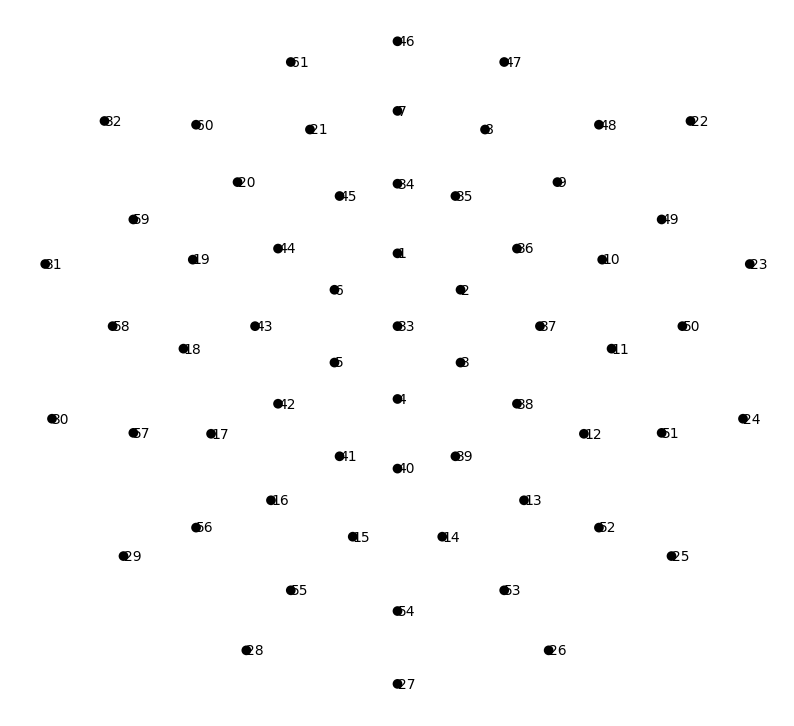

In [ ]:
# Create a montage from the electrode positions
montage = mne.channels.make_dig_montage(ch_pos=electrode_positions, coord_frame='head')

# Create a dummy info object with the same number of channels as the montage
ch_names = list(electrode_positions.keys())
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types=ch_types)

# Create a RawArray from our EEG data
segment_idx = 0
_, _, eeg_fpath = train_dataset.eegs[segment_idx]
eeg_data = np.load(eeg_fpath) # shape [n_channels (62), timesteps]
n_channels, n_times = eeg_data.shape
eeg_data_filtered = np.delete(eeg_data, 61, axis=0) # because it expects 61 channels
raw = mne.io.RawArray(eeg_data_filtered, info)

# Set the montage to the Raw object
raw.set_montage(montage)

# Plot the sensor locations
"""
fig = raw.plot_sensors(kind='3d', show_names=True)
fig.gca().view_init(azim=0, elev=90)  # viewing angle as needed
plt.show()
"""
fig, ax = plt.subplots(figsize=(10, 10))
raw.plot_sensors(kind='topomap', show_names=True, axes=ax, show=True)
plt.show()

#raw.plot()

## viz per segment and channel (electrode)

Segment 1, Electrode 1:


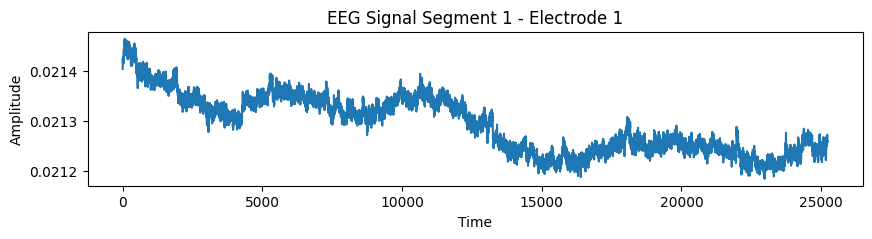

Segment 2, Electrode 1:


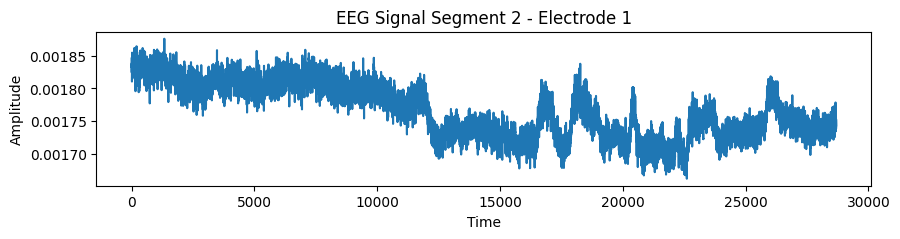

In [ ]:
# Display eeg signal per segment and electrode

def display_eeg_signal_for_segment_electrode(dataset, num_segments, electrode):
    for segment_idx in range(num_segments):
        _, _, eeg_fpath = train_dataset.eegs[segment_idx]
        eeg = np.load(eeg_fpath)
        print(f"Segment {segment_idx+1}, Electrode {electrode + 1}:")
        #print(f"  EEG Shape: {eeg.shape}, Type: {eeg.dtype}")
        #print(f"  EEG Length: {l_eeg}")

        # Debugging: Print first 5 values of the selected electrode
        #print("First 5 values of the selected segment & electrode:", eeg[electrode, :5])

        plt.figure(figsize=(10, 2))
        plt.plot(eeg[electrode, :])  # Plotting the signal of the specified electrode
        plt.title(f"EEG Signal Segment {segment_idx+1} - Electrode {electrode + 1}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()

display_eeg_signal_for_segment_electrode(train_dataset, num_segments=2, electrode=0)

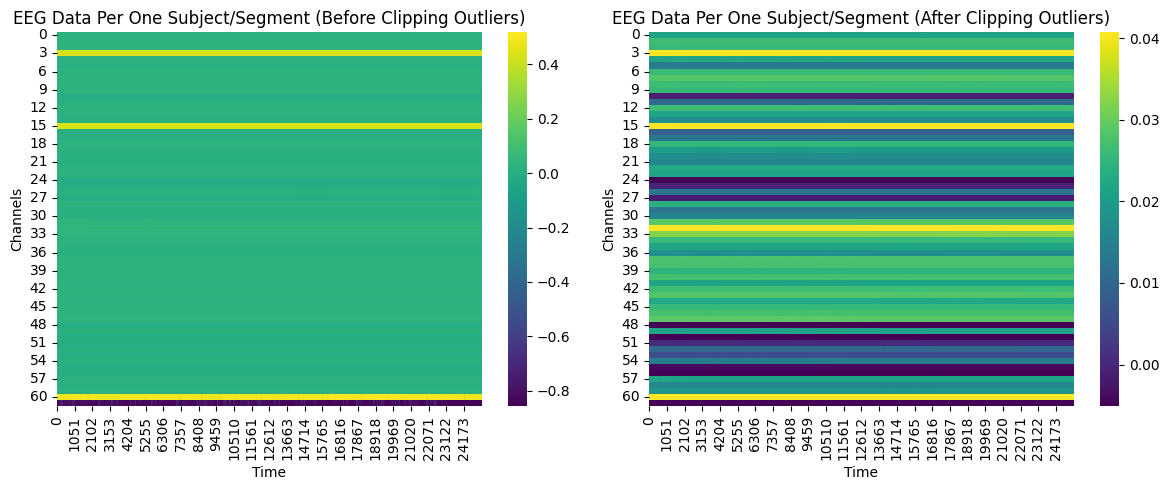

In [ ]:
# Display eeg signals per segment and all electrode

# Load the segment of EEG data
segment_idx = 0
_, _, eeg_fpath = train_dataset.eegs[segment_idx]
eeg_data = np.load(eeg_fpath) # shape [n_channels (62), timesteps]
n_channels, n_times = eeg_data.shape

# First subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(eeg_data, cmap='viridis', ax=axes[0])
axes[0].set_title('EEG Data Per One Subject/Segment (Before Clipping Outliers)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Channels')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Second subplot

# Clipping the outliers: clip values below 5th percentile and above 95th percentile
lower_bound = np.percentile(eeg_data, 5)
upper_bound = np.percentile(eeg_data, 95)
eeg_data_clipped = np.clip(eeg_data, lower_bound, upper_bound)

sns.heatmap(eeg_data_clipped, cmap='viridis', ax=axes[1])
axes[1].set_title('EEG Data Per One Subject/Segment (After Clipping Outliers)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Channels')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## stats per channels and across segments

In [ ]:
# Mean and variance per channel (one segment)

# Load the segment of EEG data
segment_idx = 0
_, _, eeg_fpath = train_dataset.eegs[segment_idx]
eeg_data = np.load(eeg_fpath) # shape [n_channels (62), timesteps]
n_channels, n_times = eeg_data.shape

# Filter the data (optional)
#eeg_data_filtered = np.delete(eeg_data, 61, axis=0)

# Plot each channel (optional)
"""
fig, axes = plt.subplots(nrows=n_channels, ncols=1, figsize=(15, 2*n_channels))
for i in range(n_channels):
    axes[i].plot(eeg_data[i, :])
    axes[i].set_title(f'Channel {i+1}')
plt.tight_layout()
plt.show()
"""

# Mean and variance
means = np.mean(eeg_data, axis=1)
variances = np.var(eeg_data, axis=1)
for i in range(n_channels):
    print(f'Channel {i+1}: Mean={means[i]:.2f}, Variance={variances[i]:.2f}')

Channel 1: Mean=0.02, Variance=0.00
Channel 2: Mean=0.03, Variance=0.00
Channel 3: Mean=0.03, Variance=0.00
Channel 4: Mean=0.44, Variance=0.00
Channel 5: Mean=0.02, Variance=0.00
Channel 6: Mean=0.01, Variance=0.00
Channel 7: Mean=0.03, Variance=0.00
Channel 8: Mean=0.03, Variance=0.00
Channel 9: Mean=0.03, Variance=0.00
Channel 10: Mean=0.03, Variance=0.00
Channel 11: Mean=-0.00, Variance=0.00
Channel 12: Mean=0.01, Variance=0.00
Channel 13: Mean=0.03, Variance=0.00
Channel 14: Mean=0.02, Variance=0.00
Channel 15: Mean=0.02, Variance=0.00
Channel 16: Mean=0.44, Variance=0.00
Channel 17: Mean=0.01, Variance=0.00
Channel 18: Mean=0.01, Variance=0.00
Channel 19: Mean=0.03, Variance=0.00
Channel 20: Mean=0.02, Variance=0.00
Channel 21: Mean=0.02, Variance=0.00
Channel 22: Mean=0.02, Variance=0.00
Channel 23: Mean=0.02, Variance=0.00
Channel 24: Mean=0.02, Variance=0.00
Channel 25: Mean=-0.01, Variance=0.00
Channel 26: Mean=-0.00, Variance=0.00
Channel 27: Mean=0.01, Variance=0.00
Channel

In [ ]:
# Mean and variance per channel (all segments)

def calculate_global_mean_variance(dataset):
    global_means = []
    global_variances = []
    n_channels = 62

    for idx in range(len(dataset)):
        _, _, eeg_fpath = dataset.eegs[idx]
        eeg_data = np.load(eeg_fpath)
        means = np.mean(eeg_data, axis=1)
        variances = np.var(eeg_data, axis=1)

        global_means.append(means)
        global_variances.append(variances)

    global_means = np.array(global_means)
    global_variances = np.array(global_variances)

    # Calculate the aggregate mean and variance for each channel
    aggregate_means = np.mean(global_means, axis=0)
    aggregate_variances = np.mean(global_variances, axis=0)

    aggregate_stats = {'Channel': np.arange(1, n_channels + 1),
                       'Mean': aggregate_means,
                       'Variance': aggregate_variances}

    return global_means, global_variances, aggregate_means, aggregate_variances, aggregate_stats

# Save the results
global_means, global_variances, aggregate_means, aggregate_variances, aggregate_stats = calculate_global_mean_variance(train_dataset)
aggregate_stats

{'Channel': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
 'Mean': array([ 7.11812471e-03,  8.49748803e-03,  6.87549372e-03, -1.92184465e-02,
        -8.96855534e-03,  6.33334272e-03,  5.83897545e-03,  3.04156816e-03,
         4.69739291e-03,  2.89447759e-03, -6.59227530e-03,  3.98466752e-04,
         5.78952376e-03,  5.08369410e-02,  5.20408610e-03,  3.24713961e-02,
         4.82779961e-03,  1.95739754e-03,  6.93152855e-03,  3.98585855e-03,
         3.07408771e-03, -5.72743742e-03, -4.70697690e-03, -2.01023050e-03,
        -1.46644030e-03, -3.55982338e-03, -1.05117795e-02, -1.70460369e-03,
        -2.17995106e-03, -8.82212440e-03, -7.21839392e-03,  8.05674197e-03,
         2.22015256e-03,  4.94506093e-03,  3.08026060e-03,  4.31851298e-03,
         3.8609

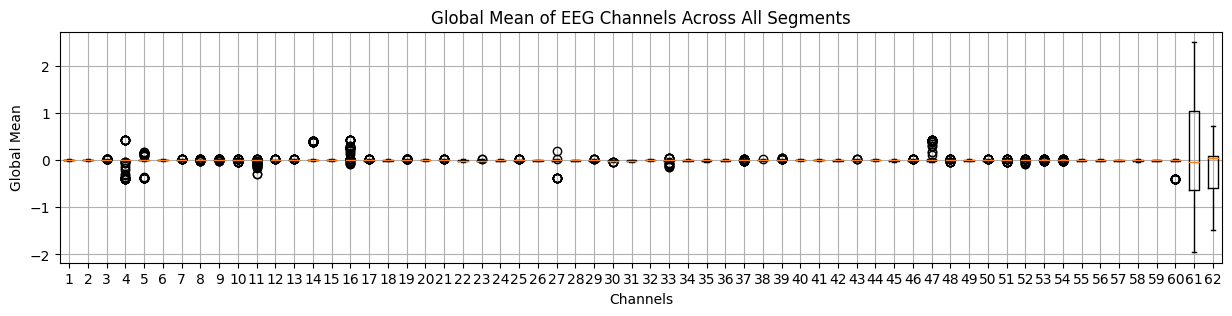

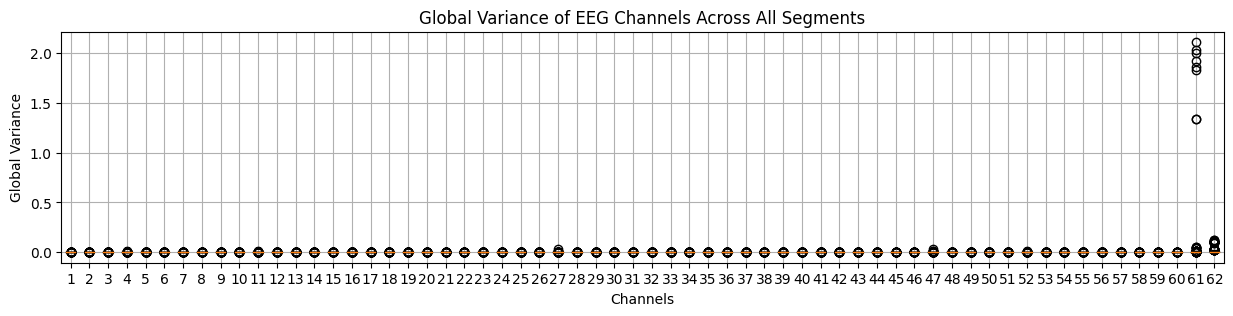

In [ ]:
# Plot the results (mean)
plt.figure(figsize=(15, 3))
plt.boxplot(global_means, labels=np.arange(1, 63))
plt.title('Global Mean of EEG Channels Across All Segments')
plt.xlabel('Channels')
plt.ylabel('Global Mean')
plt.grid(True)
plt.show()

# Plot the results (variance)
plt.figure(figsize=(15, 3))
plt.boxplot(global_variances, labels=np.arange(1, 63))
plt.title('Global Variance of EEG Channels Across All Segments')
plt.xlabel('Channels')
plt.ylabel('Global Variance')
plt.grid(True)
plt.show()

In [ ]:
# Same as above but in plotly
## Allows to remove the subject and see how the distributon changes. Set showlegend=True

# Creating box plots for global means
fig_means = go.Figure()
for i in range(global_means.shape[1]):
    fig_means.add_trace(go.Box(y=global_means[:, i], name=f'Channel {i+1}'))

fig_means.update_layout(
    title='Global Mean of EEG Channels Across All Segments',
    xaxis_title='Channels',
    yaxis_title='Global Mean',
    showlegend=True,
    xaxis=dict(tickangle=-90))

# Creating box plots for global variances
fig_variances = go.Figure()
for i in range(global_variances.shape[1]):
    fig_variances.add_trace(go.Box(y=global_variances[:, i], name=f'Channel {i+1}'))

fig_variances.update_layout(
    title='Global Variance of EEG Channels Across All Segments',
    xaxis_title='Channels',
    yaxis_title='Global Variance',
    showlegend=True,
    xaxis=dict(tickangle=-90))

fig_means.show()
fig_variances.show()

In [ ]:
# Check if the difference between channels are statistically significant (with channel 61 and 62)
mean_table_channel = pd.DataFrame(global_means)
mean_table_channel['Global_Mean'] = mean_table_channel.iloc[:, 1:].mean(axis=1)
mean_table_channel_numeric = mean_table_channel.apply(pd.to_numeric, errors='coerce', axis=1)
global_mean_all_subjects = mean_table_channel_numeric.drop(columns='Global_Mean').values.flatten().mean()
t_test_results = {}
for subject in mean_table_channel_numeric.drop(columns='Global_Mean').columns:
    subject_data = mean_table_channel_numeric[subject].values
    t_statistic, p_value = stats.ttest_1samp(subject_data, global_mean_all_subjects)
    t_test_results[subject] = t_statistic, p_value
t_test_table = pd.DataFrame({
    'Channel': t_test_results.keys(),
    'T-Statistic': [result[0] for result in t_test_results.values()],
    'P-Value': [result[1] for result in t_test_results.values()],
    'Statistically Significant': ['Yes' if result[1] < 0.05 else 'No' for result in t_test_results.values()]})
t_test_table_sorted = t_test_table.sort_values(by='Channel')
t_test_table_sorted

,Channel,T-Statistic,P-Value,Statistically Significant
0,0,5.652064,3.937318e-08,Yes
1,1,7.622569,3.979395e-13,Yes
2,2,6.016149,5.636132e-09,Yes
3,3,-2.625054,9.144711e-03,Yes
4,4,-1.929048,5.474640e-02,No
...,...,...,...,...
57,57,-8.445052,1.731693e-15,Yes
58,58,-7.564534,5.765962e-13,Yes
59,59,-5.251561,3.009257e-07,Yes
60,60,3.697846,2.621290e-04,Yes


In [ ]:
# Check if the difference between channels are statistically significant (without channel 61 and 62)
mean_table_channel = pd.DataFrame(global_means)
mean_table_channel_reduced = mean_table_channel.drop(columns=[60, 61])
mean_table_channel_reduced['Global_Mean'] = mean_table_channel_reduced.iloc[:, 1:].mean(axis=1)
mean_table_channel_numeric_reduced = mean_table_channel_reduced.apply(pd.to_numeric, errors='coerce', axis=1)
global_mean_all_subjects = mean_table_channel_numeric_reduced.drop(columns='Global_Mean').values.flatten().mean()
t_test_results = {}
for subject in mean_table_channel_numeric_reduced.drop(columns='Global_Mean').columns:
    subject_data = mean_table_channel_numeric_reduced[subject].values
    t_statistic, p_value = stats.ttest_1samp(subject_data, global_mean_all_subjects)
    t_test_results[subject] = t_statistic, p_value
t_test_table = pd.DataFrame({
    'Channel': t_test_results.keys(),
    'T-Statistic': [result[0] for result in t_test_results.values()],
    'P-Value': [result[1] for result in t_test_results.values()],
    'Statistically Significant': ['Yes' if result[1] < 0.05 else 'No' for result in t_test_results.values()]})
t_test_table_sorted = t_test_table.sort_values(by='Channel')
t_test_table_sorted

,Channel,T-Statistic,P-Value,Statistically Significant
0,0,5.995744,6.299498e-09,Yes
1,1,7.969275,4.187793e-14,Yes
2,2,6.405009,6.423931e-10,Yes
3,3,-2.595669,9.944115e-03,Yes
4,4,-1.888996,5.993689e-02,No
5,5,5.494462,8.882962e-08,Yes
6,6,4.536987,8.509980e-06,Yes
7,7,0.420998,6.740827e-01,No
8,8,2.933506,3.631924e-03,Yes
9,9,0.175786,8.605902e-01,No


## stats per channels and across subjects

In [ ]:
def calculate_subject_mean_variance(dataset):

    subject_means = defaultdict(list)
    subject_variances = defaultdict(list)

    for idx in tqdm(range(len(dataset))):
        subject_idx, _, eeg_fpath = dataset.eegs[idx]
        eeg_data = np.load(eeg_fpath)
        means = np.mean(eeg_data, axis=1)
        variances = np.var(eeg_data, axis=1)

        subject_means[subject_idx].append(means)
        subject_variances[subject_idx].append(variances)

    # Calculate the aggregate mean and variance for each subject
    aggregate_subject_means = {subj: np.mean(means, axis=0) for subj, means in subject_means.items()}
    aggregate_subject_variances = {subj: np.mean(vars, axis=0) for subj, vars in subject_variances.items()}

    return aggregate_subject_means, aggregate_subject_variances

# Compute the mean and variance for each subject in the training dataset
subject_means, subject_variances = calculate_subject_mean_variance(train_dataset)

list(subject_means.items())[:1], list(subject_variances.items())[:1]

100%|██████████| 278/278 [00:05<00:00, 49.05it/s]


([('S42',
   array([ 2.17948455e-02,  2.68102215e-02,  2.61172461e-02,  4.38082178e-01,
           2.15693478e-02,  1.42091315e-02,  2.63673907e-02,  2.85913216e-02,
           2.65257695e-02,  2.57198710e-02, -1.00718549e-03,  1.10971234e-02,
           2.64628496e-02,  2.18106642e-02,  1.74626993e-02,  4.36448096e-01,
           9.87956987e-03,  1.36366049e-02,  2.53793015e-02,  2.07547002e-02,
           1.78502270e-02,  1.65355867e-02,  2.28362829e-02,  2.15035956e-02,
          -1.00615237e-02, -6.67000988e-04,  1.28475577e-02, -1.67006463e-03,
           2.43922864e-02,  1.30740386e-02,  1.50533836e-02,  2.90402469e-02,
           4.02652249e-02,  3.17311058e-02,  2.59851950e-02,  2.20824352e-02,
           1.80354242e-02,  2.76441298e-02,  2.73515389e-02,  2.48007102e-02,
           2.70995319e-02,  2.22256636e-02,  2.67327221e-02,  2.85744215e-02,
           2.28358088e-02,  2.57669535e-02,  2.71883445e-02,  2.89994395e-02,
          -5.20775856e-03,  2.17003953e-02, -5.2202528

In [ ]:
# Create dataframes for mean and variance using the aggregated data
mean_table = pd.DataFrame.from_dict(subject_means, orient='index')
variance_table = pd.DataFrame.from_dict(subject_variances, orient='index')

# Reset index to turn the keys into a column (subjects)
mean_table.reset_index(inplace=True)
variance_table.reset_index(inplace=True)

# Rename columns
mean_table.columns = ['Subject'] + [f'Channel_{i}' for i in range(1, mean_table.shape[1])]
variance_table.columns = ['Subject'] + [f'Channel_{i}' for i in range(1, variance_table.shape[1])]

# Calculate a global mean and variance per subject across all channels
mean_table['Global_Mean'] = mean_table.iloc[:, 1:].mean(axis=1)
variance_table['Global_Variance'] = variance_table.iloc[:, 1:].mean(axis=1)

# Show the first few rows of each table
variance_table.head()
mean_table.head()

,Subject,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Channel_9,Channel_10,Channel_11,Channel_12,Channel_13,Channel_14,Channel_15,Channel_16,Channel_17,Channel_18,Channel_19,Channel_20,Channel_21,Channel_22,Channel_23,Channel_24,Channel_25,Channel_26,Channel_27,Channel_28,Channel_29,Channel_30,Channel_31,Channel_32,Channel_33,Channel_34,Channel_35,Channel_36,Channel_37,Channel_38,Channel_39,Channel_40,Channel_41,Channel_42,Channel_43,Channel_44,Channel_45,Channel_46,Channel_47,Channel_48,Channel_49,Channel_50,Channel_51,Channel_52,Channel_53,Channel_54,Channel_55,Channel_56,Channel_57,Channel_58,Channel_59,Channel_60,Channel_61,Channel_62,Global_Mean
0,S42,0.021795,0.026810,0.026117,0.438082,0.021569,0.014209,0.026367,0.028591,0.026526,0.025720,-0.001007,0.011097,0.026463,0.021811,0.017463,0.436448,0.009880,0.013637,0.025379,0.020755,0.017850,0.016536,0.022836,0.021504,-0.010062,-0.000667,0.012848,-0.001670,0.024392,0.013074,0.015053,0.029040,0.040265,0.031731,0.025985,0.022082,0.018035,0.027644,0.027352,0.024801,0.027100,0.022226,0.026733,0.028574,0.022836,0.025767,0.027188,0.028999,-0.005208,0.021700,-0.005220,0.000315,0.010463,0.005509,0.014325,-0.003661,-0.004941,0.022108,0.016183,0.019596,0.535105,-0.581380,0.030172
1,S39,0.001911,-0.012163,-0.002607,-0.002127,0.144766,0.003347,-0.006284,-0.007180,-0.003273,0.000239,0.004103,0.001053,0.006301,0.004708,0.006034,0.006227,0.004111,-0.003207,0.004004,0.005495,0.001493,0.004845,0.004249,-0.007759,0.004933,0.004180,-0.001269,0.003984,-0.003546,0.004096,-0.019901,0.005907,0.007134,-0.000498,0.000146,0.003514,-0.003844,-0.001037,0.011870,0.005064,0.008831,0.001192,-0.003123,-0.003690,-0.002789,-0.005770,0.007004,0.001416,0.001968,-0.003270,0.004939,0.004109,-0.000965,0.005114,0.000708,-0.001377,0.000679,0.004280,0.003900,0.007990,-1.180217,-1.206883,-0.035112
2,S11,-0.008415,-0.001033,-0.004566,0.001698,-0.008911,-0.004902,-0.015057,-0.007571,-0.000082,-0.002391,-0.003229,-0.010480,-0.012931,-0.010487,0.001616,0.002121,-0.004722,-0.005902,-0.005135,-0.001110,-0.011678,-0.006594,-0.015851,-0.010726,-0.007805,-0.003250,0.001153,-0.001771,-0.007286,-0.026971,-0.014020,-0.013346,-0.013820,-0.012460,-0.003161,-0.000166,-0.005499,-0.002255,-0.004752,-0.005844,-0.015192,-0.009467,-0.007317,-0.001020,-0.004076,-0.005899,-0.011157,-0.007975,0.002238,-0.004640,-0.011758,-0.002772,-0.009682,0.000704,0.000316,-0.002910,-0.004523,-0.008164,0.002345,-0.012287,-0.793456,0.098852,-0.017346
3,S45,0.000545,0.003929,0.006149,-0.005942,0.007747,0.008570,0.000576,0.001192,0.006648,0.007447,-0.005797,-0.016670,0.007333,0.003932,0.013992,0.000545,0.005348,-0.003719,0.006571,-0.005315,-0.001711,-0.021827,-0.033009,0.006193,-0.020014,-0.009178,-0.018464,-0.014834,-0.005832,-0.014343,-0.000448,0.007122,0.009784,0.008680,0.003257,-0.015571,0.000380,0.001993,0.010557,0.010331,0.005613,-0.001794,0.006935,0.003455,0.000365,0.003955,0.004072,-0.028652,-0.001175,0.003482,-0.004401,-0.009873,-0.001208,0.005739,-0.008278,-0.004199,0.002910,0.005047,-0.003660,0.009167,2.509329,-0.408841,0.032809
4,S41,0.027920,0.021729,0.025123,-0.302628,0.022772,0.025224,0.012037,0.009265,0.003052,-0.014414,-0.095993,-0.009951,0.015303,0.012771,0.016101,0.025916,-0.014411,-0.005851,0.016112,0.019974,0.029961,-0.014201,-0.006278,-0.007091,-0.011652,-0.010844,-0.012245,-0.015005,-0.010318,-0.010549,0.000189,0.020489,0.022578,-0.010991,-0.005145,-0.013696,0.007127,0.013809,0.008766,0.018047,0.017437,0.034347,0.014945,0.025445,-0.013121,-0.001239,-0.012826,-0.009090,-0.016565,-0.005215,-0.016630,-0.015017,-0.013230,-0.015102,-0.010542,-0.013947,-0.013276,-0.012034,0.010157,0.018446,0.913258,-1.375351,-0.011389


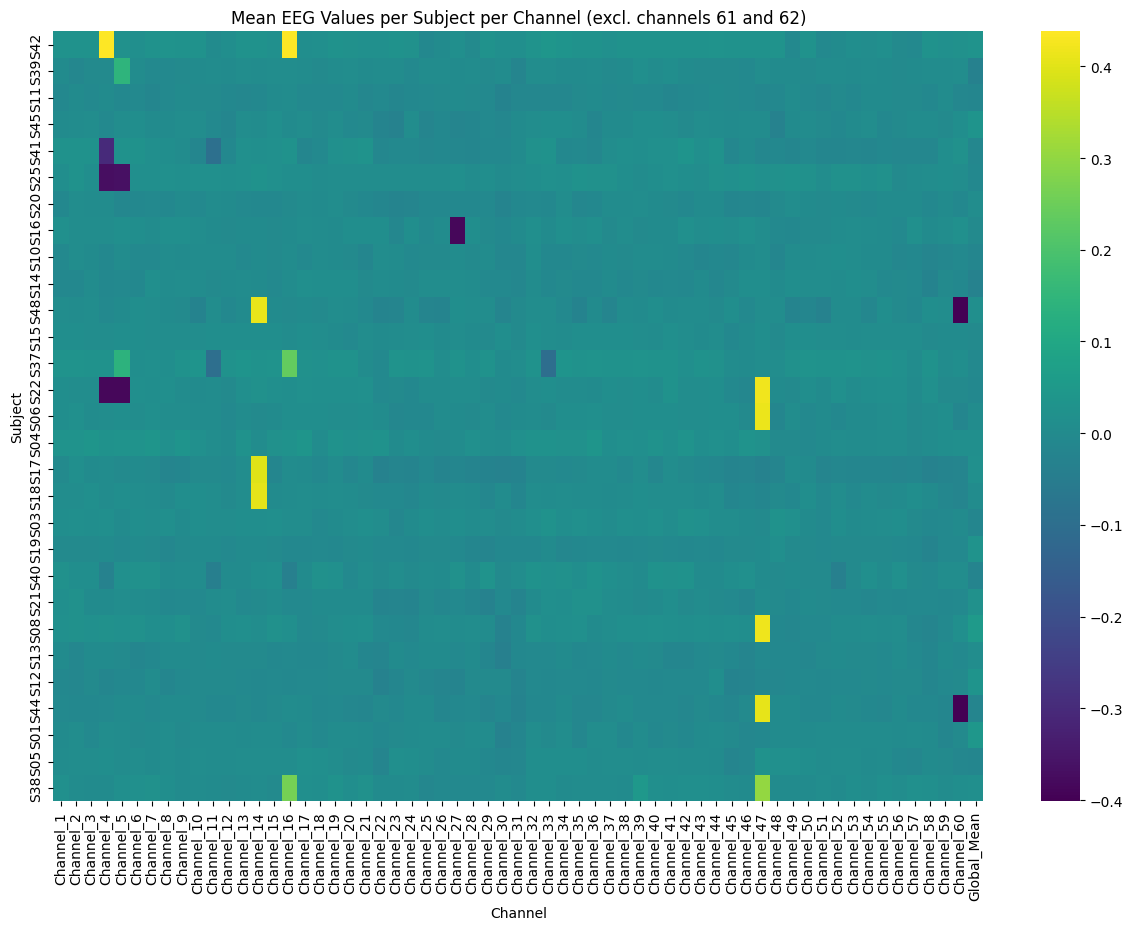

In [ ]:
# Drop columns for Channel 61 and 62
mean_table_2 = mean_table.drop(['Channel_61', 'Channel_62'], axis=1)
variance_table_2 = variance_table.drop(['Channel_61', 'Channel_62'], axis=1)

# Plot heatmap for means
plt.figure(figsize=(15, 10))
sns.heatmap(mean_table_2.set_index('Subject'), cmap='viridis', annot=False, fmt=".2f")
plt.title('Mean EEG Values per Subject per Channel (excl. channels 61 and 62)')
plt.xlabel('Channel')
plt.ylabel('Subject')
plt.show()

# Plot heatmap for variances
#plt.figure(figsize=(15, 10))
#sns.heatmap(variance_table_2.set_index('Subject'), cmap='viridis', annot=False, fmt=".2f")
#plt.title('Variance of EEG Values per Subject per Channel')
#plt.xlabel('Channel')
#plt.ylabel('Subject')
#plt.show()

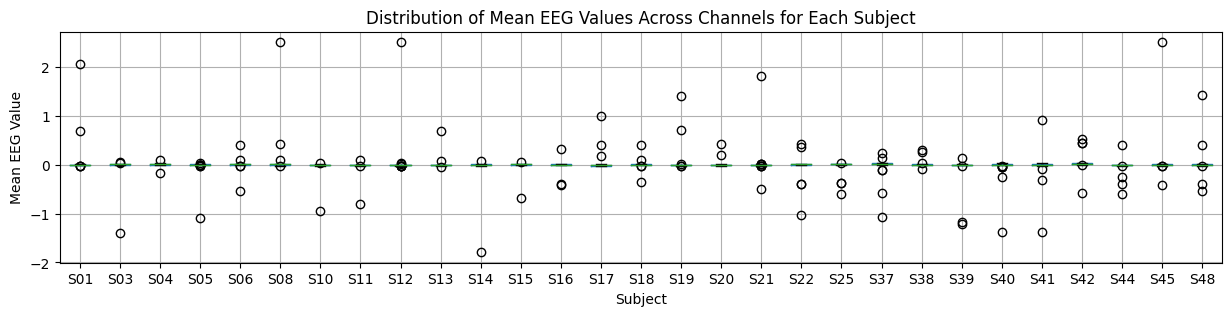

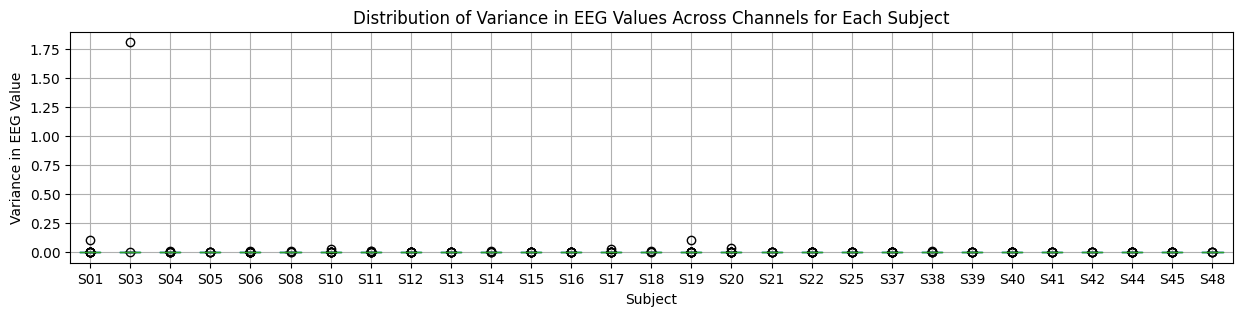

In [ ]:
mean_table = pd.DataFrame(subject_means)
variance_table = pd.DataFrame(subject_variances)

sorted_mean_table = mean_table[sorted(mean_table.columns)]
sorted_variance_table = variance_table[sorted(variance_table.columns)]

# Plot the boxplot for mean values
plt.figure(figsize=(15, 3))
sorted_mean_table.boxplot()
plt.title('Distribution of Mean EEG Values Across Channels for Each Subject')
plt.xlabel('Subject')
plt.ylabel('Mean EEG Value')
plt.show()

# Plot the boxplot for variance values
plt.figure(figsize=(15, 3))
sorted_variance_table.boxplot()
plt.title('Distribution of Variance in EEG Values Across Channels for Each Subject')
plt.xlabel('Subject')
plt.ylabel('Variance in EEG Value')
plt.show()

In [ ]:
# Same as above but in plotly
## Allows to remove the subject and see how the distributon changes. Set showlegend=True

# Plotly boxplots for mean values
mean_fig = go.Figure()
for column in sorted_mean_table.columns:
    mean_fig.add_trace(go.Box(y=sorted_mean_table[column], name=column))

mean_fig.update_layout(
    title='Distribution of Mean EEG Values Across Channels for Each Subject',
    xaxis_title='Subject',
    yaxis_title='Mean EEG Value',
    showlegend=True,
    height=600)

# Plotly boxplots for variance values
variance_fig = go.Figure()
for column in sorted_variance_table.columns:
    variance_fig.add_trace(go.Box(y=sorted_variance_table[column], name=column))

variance_fig.update_layout(
    title='Distribution of Variance in EEG Values Across Channels for Each Subject',
    xaxis_title='Subject',
    showlegend=True,
    yaxis_title='Variance in EEG Value',
    height=600)

# Display the figures
mean_fig.show()
variance_fig.show()

In [ ]:
# Check if the difference between subjects are statistically significant
mean_table = pd.DataFrame(subject_means)
mean_table['Global_Mean'] = mean_table.iloc[:, 1:].mean(axis=1)
mean_table_numeric = mean_table.apply(pd.to_numeric, errors='coerce', axis=1)
global_mean_all_subjects = mean_table_numeric.drop(columns='Global_Mean').values.flatten().mean()
t_test_results = {}
for subject in mean_table_numeric.drop(columns='Global_Mean').columns:
    subject_data = mean_table_numeric[subject].values
    t_statistic, p_value = stats.ttest_1samp(subject_data, global_mean_all_subjects)
    t_test_results[subject] = t_statistic, p_value
t_test_table = pd.DataFrame({
    'Subject': t_test_results.keys(),
    'T-Statistic': [result[0] for result in t_test_results.values()],
    'P-Value': [result[1] for result in t_test_results.values()],
    'Statistically Significant': ['Yes' if result[1] < 0.05 else 'No' for result in t_test_results.values()]})
t_test_table_sorted = t_test_table.sort_values(by='Subject')
t_test_table_sorted

,Subject,T-Statistic,P-Value,Statistically Significant
26,S01,1.157686,0.251505,No
18,S03,-0.814751,0.418384,No
15,S04,2.742662,0.007989,Yes
27,S05,-1.015445,0.313904,No
14,S06,-0.018432,0.985355,No
22,S08,1.245121,0.217849,No
8,S10,-1.343804,0.183989,No
2,S11,-1.620466,0.110291,No
24,S12,0.729550,0.468457,No
23,S13,0.236679,0.813699,No


# **models**

## replicated meta models

Relevant Meta folders: [Features folder](https://github.com/facebookresearch/brainmagick/tree/main/bm/features) and [Model folder](https://github.com/facebookresearch/brainmagick/tree/main/bm/models).


**Shared model components and models:**

1. **[common.py](https://github.com/facebookresearch/brainmagick/blob/main/bm/models/common.py)** - collection of components used by other models

  - ScaledEmbedding

  - SubjectLayers

  - LayerScale

  - ConvSequence

  - DualPathRNN

  - PositionGetter

  - FourierEmb

  - ChannelDropout

  - ChannelMerger

2. **[convrnn.py](https://github.com/facebookresearch/brainmagick/blob/main/bm/models/convrnn.py)** - a model used both as an a encoder and a decoder.

  - LSTM

  - Attention

  - ConvRNN
  
    - SubjectLayers (subject layer)

    - ScaledEmbedding (subject embedding)
    
    - LSTM (bidirectional)

    - Attention (multi-head dot product)

    - ConvSequence (decoder)
  
    - Conv1d or Conv1d + ReLU + Conv1d (final)

3. **[simpleconv.py](https://github.com/facebookresearch/brainmagick/blob/main/bm/models/simpleconv.py)**

  - SimpleConv

    - takes a sample of channels (subsampled_meg_channels)
    
    - ChannelDropout

    - ChannelMerger

    - Conv1d + activations (initial layer)

    - SubjectLayers (subject layer)

    - ta.transforms.Spectrogram (short-time fourier transform)

    - ScaledEmbedding (subject embedding)

    - ConvSequence (encoder)

    - DualPathRNN
  
    - Conv1d or Conv1d + ReLU + Conv1d (final)

4. **[features.py](https://github.com/facebookresearch/brainmagick/blob/main/bm/models/features.py)** - model to extract features

  - DeepMel(ConvSequence)

**Combined encoders:**

1. **[deep_mel.yaml](https://github.com/facebookresearch/brainmagick/blob/main/bm/conf/feature_model/deep_mel.yaml)** - calls **features.py** - feature model

2. **[convrnn.yaml](https://github.com/facebookresearch/brainmagick/blob/main/bm/conf/model/convrnn.yaml)** - calls **convrnn.py**

**Combined decoders:**

1. **[clip_conv.yaml](https://github.com/facebookresearch/brainmagick/blob/main/bm/conf/model/clip_conv.yaml/)** - calls **simpleconv.py** - default model

2. **[decoder_convrnn.yaml](https://github.com/facebookresearch/brainmagick/blob/main/bm/conf/model/decoder_convrnn.yaml)** - calls **convrnn.py**


Other: All the imports https://github.com/facebookresearch/brainmagick/blob/main/requirements.txt

### brain encoder (replicated meta's convrnn)

In [ ]:
class SubjectLayers(nn.Module): # learn how different are the subjects and based on that normalize the EEG
    def __init__(self, in_channels, out_channels, n_subjects):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(n_subjects, in_channels, out_channels)) # initialize weights for each subject
        self.weights.data *= 1 / in_channels**0.5 # normalize weights

    def forward(self, x, n_subjects):
        _, C, D = self.weights.shape
        subject_weights = self.weights.gather(0, n_subjects.view(-1, 1, 1).expand(-1, C, D)) # select the appropriate weights for each subject in the batch
        transformed_eeg = torch.einsum("bct,bcd->bdt", x, subject_weights) # apply the subject-specific transformations

        return transformed_eeg

class ScaledEmbedding(nn.Module): # assign a unique vector to each subject (similar to positional embedding)

    def __init__(self, n_subjects, embedding_dim, scale):

        super().__init__()
        self.embedding = nn.Embedding(n_subjects, embedding_dim)
        self.embedding.weight.data /= scale
        self.scale = scale

    def forward(self, x):
        scaled_embedding = self.embedding(x) * self.scale
        return scaled_embedding

class LayerScale(nn.Module):
    def __init__(self, channels, init = 0.1, boost = 5.):
        super().__init__()
        self.scale = nn.Parameter(torch.zeros(channels, requires_grad=True))
        self.scale.data[:] = init / boost
        self.boost = boost

    def forward(self, x):
        return (self.boost * self.scale[:, None]) * x

class ConvSequence(nn.Module):

    def __init__(self,
                 channels = [16, 32, 64, 128],
                 kernel = 4, dilation_growth = 1, dilation_period = None,
                 stride = 2, dropout = 0.0, leakiness = 0.0,
                 groups = 1, decode = False, batch_norm = False,
                 dropout_input = 0, skip = False, scale = None,
                 rewrite = False, activation_on_last = True,
                 post_skip = False, glu = 0, glu_context = 0,
                 glu_glu = True, activation = None):

        super().__init__()
        dilation = 1
        channels = tuple(channels)
        self.skip = skip
        self.sequence = nn.ModuleList()
        self.glus = nn.ModuleList()
        if activation is None:
            activation = partial(nn.LeakyReLU, leakiness)
        Conv = nn.Conv1d if not decode else nn.ConvTranspose1d
        # build layers
        for k, (chin, chout) in enumerate(zip(channels[:-1], channels[1:])):
            layers: tp.List[nn.Module] = []
            is_last = k == len(channels) - 2

            # Set dropout for the input of the conv sequence if defined
            if k == 0 and dropout_input:
                assert 0 < dropout_input < 1
                layers.append(nn.Dropout(dropout_input))

            # conv layer
            if dilation_growth > 1:
                assert kernel % 2 != 0 # supports only odd kernel with dilation
            if dilation_period and (k % dilation_period) == 0:
                dilation = 1
            pad = kernel // 2 * dilation
            layers.append(Conv(chin, chout, kernel, stride, pad,
                               dilation=dilation, groups=groups if k > 0 else 1))
            dilation *= dilation_growth
            # non-linearity
            if activation_on_last or not is_last:
                if batch_norm:
                    layers.append(nn.BatchNorm1d(num_features=chout))
                layers.append(activation())
                if dropout:
                    layers.append(nn.Dropout(dropout))
                if rewrite:
                    layers += [nn.Conv1d(chout, chout, 1), nn.LeakyReLU(leakiness)]
            if chin == chout and skip:
                if scale is not None:
                    layers.append(LayerScale(chout, scale))
                if post_skip:
                    layers.append(Conv(chout, chout, 1, groups=chout, bias=False))

            self.sequence.append(nn.Sequential(*layers))
            if glu and (k + 1) % glu == 0:
                ch = 2 * chout if glu_glu else chout
                act = nn.GLU(dim=1) if glu_glu else activation()
                self.glus.append(
                    nn.Sequential(
                        nn.Conv1d(chout, ch, 1 + 2 * glu_context, padding=glu_context), act))
            else:
                self.glus.append(None)

    def forward(self, x):
        for module_idx, module in enumerate(self.sequence):
            old_x = x
            x = module(x)
            if self.skip and x.shape == old_x.shape:
                x = x + old_x
            glu = self.glus[module_idx]
            if glu is not None:
                x = glu(x)
        return x

class Attention(nn.Module): # scaled dot product with relative position encoding and local attention
    def __init__(self, channels, radius = 50, heads = 4):
        super().__init__()
        assert channels % heads == 0
        self.content = nn.Conv1d(channels, channels, 1)
        self.query = nn.Conv1d(channels, channels, 1)
        self.key = nn.Conv1d(channels, channels, 1)
        self.embedding = nn.Embedding(radius * 2 + 1, channels // heads)
        weight = self.embedding.weight.data
        weight[:] = weight.cumsum(0) / torch.arange(1, len(weight) + 1).float().view(-1, 1).sqrt()
        self.heads = heads
        self.radius = radius
        self.bn = nn.BatchNorm1d(channels)
        self.fc = nn.Conv1d(channels, channels, 1)
        self.scale = nn.Parameter(torch.full([channels], 0.1))

    def forward(self, x):

        def _split(y):
            return y.view(y.shape[0], self.heads, -1, y.shape[2])

        content = _split(self.content(x))
        query = _split(self.query(x))
        key = _split(self.key(x))

        batch_size, _, dim, length = content.shape

        dots = torch.einsum("bhct,bhcs->bhts", query, key) # first index `t` is query, second index `s` is key.

        steps = torch.arange(length, device=x.device)
        relative = (steps[:, None] - steps[None, :])
        embs = self.embedding.weight.gather(0, self.radius + relative.clamp_(-self.radius, self.radius).view(-1, 1).expand(-1, dim))
        embs = embs.view(length, length, -1)
        dots += 0.3 * torch.einsum("bhct,tsc->bhts", query, embs)
        dots = torch.where(
            relative.abs() <= self.radius, dots, torch.tensor(-float('inf')).to(embs))

        weights = torch.softmax(dots, dim=-1)
        out = torch.einsum("bhts,bhcs->bhct", weights, content)
        out += 0.3 * torch.einsum("bhts,tsc->bhct", weights, embs)
        out = out.reshape(batch_size, -1, length)
        out = F.relu(self.bn(self.fc(out))) * self.scale.view(1, -1, 1)
        return out

"""
# TEST 1
def test_subject_layers():
    batch_size = 2
    in_channels = 3
    out_channels = 2
    n_subjects = 1
    time_steps = 2
    eeg_data = torch.randn(batch_size, in_channels, time_steps)
    print(eeg_data)
    subjects = torch.randint(0, n_subjects, (batch_size,))
    print(subjects)
    subject_layers = SubjectLayers(in_channels, out_channels, n_subjects)
    output = subject_layers(eeg_data, subjects)
    expected_shape = (batch_size, out_channels, time_steps)
    assert output.shape == expected_shape, f"Output shape mismatch: expected {expected_shape}, got {output.shape}"
test_subject_layers()

# TEST 2
def scaled_embedding():
  n_subjects = 10
  embedding_dim = 5
  scale = 10
  scaled_embedding = ScaledEmbedding(n_subjects, embedding_dim, scale)
  subject_indices = torch.tensor([1, 2])
  embeddings = scaled_embedding(subject_indices)
  print(embeddings)
scaled_embedding()

# TEST 3
conv_sequence = ConvSequence(channels=[16, 32, 64, 128])
input_tensor = torch.randn(1, 16, 50) # (Batch Size, Channels, Length)
output = conv_sequence(input_tensor)
output.shape
#summary(conv_sequence, input_size=(16, 50))
"""

'\n# TEST 1\ndef test_subject_layers():\n    batch_size = 2\n    in_channels = 3\n    out_channels = 2\n    n_subjects = 1\n    time_steps = 2\n    eeg_data = torch.randn(batch_size, in_channels, time_steps)\n    print(eeg_data)\n    subjects = torch.randint(0, n_subjects, (batch_size,))\n    print(subjects)\n    subject_layers = SubjectLayers(in_channels, out_channels, n_subjects)\n    output = subject_layers(eeg_data, subjects)\n    expected_shape = (batch_size, out_channels, time_steps)\n    assert output.shape == expected_shape, f"Output shape mismatch: expected {expected_shape}, got {output.shape}"\ntest_subject_layers()\n\n# TEST 2\ndef scaled_embedding():\n  n_subjects = 10\n  embedding_dim = 5\n  scale = 10\n  scaled_embedding = ScaledEmbedding(n_subjects, embedding_dim, scale)\n  subject_indices = torch.tensor([1, 2])\n  embeddings = scaled_embedding(subject_indices)\n  print(embeddings)\nscaled_embedding()\n\n# TEST 3\nconv_sequence = ConvSequence(channels=[16, 32, 64, 128])\

In [ ]:
class Meta_EEG_Encoder(nn.Module):

    def __init__(self,

                 in_channels = 64, n_subjects = 30,

                 # subject layers
                 out_channels = 128,

                 # conv
                 conv_chanels = [16, 32, 64, 128],
                 kernel = 4, stride = 2, conv_dropout = 0,
                 batch_norm = False, dropout_input = 0,
                 leakiness = 0,

                 # lstm
                 hidden_size = 128, lstm_layers = 4, lstm_dropout = 0.1,

                 # attention
                 attention_heads = 4, subject_dim = 64, embedding_scale = 1.0):

        super().__init__()

        # subject layers (normalization across subjects)
        self.subject_layers = SubjectLayers(in_channels, out_channels, n_subjects)

        # scaled embedding (optional)
        # self.subject_embedding = ScaledEmbedding(n_subjects, subject_dim, embedding_scale)

        # convsequence
        self.convs = ConvSequence(channels=conv_chanels, kernel = kernel_size,
                                  stride = stride, dropout = conv_dropout,
                                  batch_norm = batch_norm, leakiness = leakiness,
                                  dropout_input = dropout_input)

        # lstm
        self.lstm = nn.LSTM(input_size    = out_channels,
                            hidden_size   = hidden_size//2,
                            num_layers    = lstm_layers,
                            dropout       = lstm_dropout,
                            bidirectional = True,
                            batch_first    = True)

        # attention
        self.attention = Attention(hidden_size, heads=attention_heads)

        # final linear layer
        self.finalconv1 = nn.Conv1d(hidden_size, out_channels, kernel_size = 1)

    def forward(self, eeg_inputs): # to pass as an additional paramater n_subjects=10

        # subject layers
        # subject_indices = torch.arange(n_subjects).to(eeg_inputs.device)
        # normalized_eeg_inputs = self.subject_layers(eeg_inputs, subject_indices)

        # scaled embedding // scaled_embedding = self.subject_embedding(subject_indices)

        # convsequence
        print('eeg_inputs before convs', eeg_inputs.shape)
        out = self.convs(eeg_inputs)
        print('eeg_inputs after convs', out.shape)
        print("After convs:", torch.isnan(out).any())

        # lstm
        out = out.permute(2, 0, 1)
        out, _ = self.lstm(out)
        out = out.permute(1, 2, 0)
        print("After LSTM:", torch.isnan(out).any())

        # attention
        out = out + self.attention(out)
        print("After Attention:", torch.isnan(out).any())

        # decoder
        # out = self.decoder(out)

        # final
        out = self.finalconv1(out)
        print("Final Output:", torch.isnan(out).any())

        return out

# TEST
in_channels = 64
n_subjects = 30
out_channels = 128
conv_channels = [64, 32, 64, 128]
kernel_size = 4
stride = 2
conv_dropout = 0
batch_norm = False
dropout_input = 0
leakiness = 0
hidden_size = 128
lstm_layers = 4
lstm_dropout = 0.1
attention_heads = 4
subject_dim = 64
embedding_scale = 1.0

eeg_encoder = Meta_EEG_Encoder(in_channels = 62,
                               n_subjects = 33,
                               out_channels = 128,
                               conv_chanels = [62, 32, 64, 128],
                               kernel = 2,
                               stride = 2,
                               conv_dropout = 0,
                               batch_norm = False,
                               dropout_input = 0,
                               leakiness = 0,
                               hidden_size = 512,
                               lstm_layers = 4,
                               lstm_dropout = 0.1,
                               attention_heads = 8,
                               subject_dim = 64,
                               embedding_scale = 1.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eeg_encoder.to(device)
batch_size = 2
in_channels = 62
sequence_length = 128
x_sample = torch.rand(batch_size, in_channels, sequence_length)
summary(eeg_encoder, x_sample.to(device))

eeg_inputs before convs torch.Size([2, 62, 128])
eeg_inputs after convs torch.Size([2, 128, 17])
After convs: tensor(False, device='cuda:0')
After LSTM: tensor(False, device='cuda:0')
After Attention: tensor(False, device='cuda:0')
Final Output: tensor(False, device='cuda:0')
                                 Kernel Shape  Output Shape     Params  \
Layer                                                                    
0_convs.sequence.0.Conv1d_0       [62, 32, 4]   [2, 32, 65]     7.968k   
1_convs.sequence.0.LeakyReLU_1              -   [2, 32, 65]          -   
2_convs.sequence.1.Conv1d_0       [32, 64, 4]   [2, 64, 33]     8.256k   
3_convs.sequence.1.LeakyReLU_1              -   [2, 64, 33]          -   
4_convs.sequence.2.Conv1d_0      [64, 128, 4]  [2, 128, 17]    32.896k   
5_convs.sequence.2.LeakyReLU_1              -  [2, 128, 17]          -   
6_lstm                                      -  [17, 2, 512]  5.521408M   
7_attention.Conv1d_content      [512, 512, 1]  [2, 512, 1

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_convs.sequence.0.Conv1d_0,"[62, 32, 4]","[2, 32, 65]",7968.0,515840.0
1_convs.sequence.0.LeakyReLU_1,-,"[2, 32, 65]",NaN,NaN
2_convs.sequence.1.Conv1d_0,"[32, 64, 4]","[2, 64, 33]",8256.0,270336.0
3_convs.sequence.1.LeakyReLU_1,-,"[2, 64, 33]",NaN,NaN
4_convs.sequence.2.Conv1d_0,"[64, 128, 4]","[2, 128, 17]",32896.0,557056.0
5_convs.sequence.2.LeakyReLU_1,-,"[2, 128, 17]",NaN,NaN
6_lstm,-,"[17, 2, 512]",5521408.0,5505024.0
7_attention.Conv1d_content,"[512, 512, 1]","[2, 512, 17]",262656.0,4456448.0
8_attention.Conv1d_query,"[512, 512, 1]","[2, 512, 17]",262656.0,4456448.0


### audio encoder (replicated meta's deepmel)

In [ ]:
# Speech model

class LayerScale(nn.Module):
    def __init__(self, channels: int, init: float = 0.1, boost: float = 5.):
        super().__init__()
        self.scale = nn.Parameter(torch.zeros(channels, requires_grad=True))
        self.scale.data[:] = init / boost
        self.boost = boost

    def forward(self, x):
        return (self.boost * self.scale[:, None]) * x

class ConvSequence(nn.Module):

    def __init__(self,
                 channels: tp.Sequence[int],
                 kernel: int = 4,
                 dilation_growth: int = 1,
                 dilation_period: tp.Optional[int] = None,
                 stride: int = 2,
                 dropout: float = 0.0,
                 leakiness: float = 0.0,
                 groups: int = 1,
                 decode: bool = False,
                 batch_norm: bool = False,
                 dropout_input: float = 0,
                 skip: bool = False,
                 scale: tp.Optional[float] = None,
                 rewrite: bool = False,
                 activation_on_last: bool = True,
                 post_skip: bool = False,
                 glu: int = 0,
                 glu_context: int = 0,
                 glu_glu: bool = True,
                 activation: tp.Any = None) -> None:
        super().__init__()
        dilation = 1
        channels = tuple(channels)
        self.skip = skip
        self.sequence = nn.ModuleList()
        self.glus = nn.ModuleList()
        if activation is None:
            activation = partial(nn.LeakyReLU, leakiness)
        Conv = nn.Conv1d if not decode else nn.ConvTranspose1d
        # build layers
        for k, (chin, chout) in enumerate(zip(channels[:-1], channels[1:])):
            layers: tp.List[nn.Module] = []
            is_last = k == len(channels) - 2

            # Set dropout for the input of the conv sequence if defined
            if k == 0 and dropout_input:
                assert 0 < dropout_input < 1
                layers.append(nn.Dropout(dropout_input))

            # conv layer
            if dilation_growth > 1:
                assert kernel % 2 != 0, "Supports only odd kernel with dilation for now"
            if dilation_period and (k % dilation_period) == 0:
                dilation = 1
            pad = kernel // 2 * dilation
            layers.append(Conv(chin, chout, kernel, stride, pad,
                               dilation=dilation, groups=groups if k > 0 else 1))
            dilation *= dilation_growth
            # non-linearity
            if activation_on_last or not is_last:
                if batch_norm:
                    layers.append(nn.BatchNorm1d(num_features=chout))
                layers.append(activation())
                if dropout:
                    layers.append(nn.Dropout(dropout))
                if rewrite:
                    layers += [nn.Conv1d(chout, chout, 1), nn.LeakyReLU(leakiness)]
                    # layers += [nn.Conv1d(chout, 2 * chout, 1), nn.GLU(dim=1)]
            if chin == chout and skip:
                if scale is not None:
                    layers.append(LayerScale(chout, scale))
                if post_skip:
                    layers.append(Conv(chout, chout, 1, groups=chout, bias=False))

            self.sequence.append(nn.Sequential(*layers))
            if glu and (k + 1) % glu == 0:
                ch = 2 * chout if glu_glu else chout
                act = nn.GLU(dim=1) if glu_glu else activation()
                self.glus.append(
                    nn.Sequential(
                        nn.Conv1d(chout, ch, 1 + 2 * glu_context, padding=glu_context), act))
            else:
                self.glus.append(None)

    def forward(self, x: tp.Any) -> tp.Any:
        for module_idx, module in enumerate(self.sequence):
            old_x = x
            x = module(x)
            if self.skip and x.shape == old_x.shape:
                x = x + old_x
            glu = self.glus[module_idx]
            if glu is not None:
                x = glu(x)
        return x

class DeepMel(ConvSequence):
    """DeepMel model that extracts features from the Mel spectrogram.

    Parameters
    ----------
    n_in_channels :
        Number of input channels.
    n_hidden_channels :
        Number of channels in hidden layers.
    n_hidden_layers :
        Number of hidden layers.
    n_out_channels :
        Number of output channels.
    kwargs:
        Additional keyword arguments to pass to ConvSequence.
    """
    def __init__(self,
                 n_in_channels: int,
                 n_hidden_channels: int,
                 n_hidden_layers: int,
                 n_out_channels: int, **kwargs):

        channels = \
            [n_in_channels] + [n_hidden_channels] * (n_hidden_layers - 1) + [n_out_channels]

        super().__init__(channels, **kwargs)

# Test the model
n_in_channels = 16
n_hidden_channels = 32
n_hidden_layers = 3
n_out_channels = 64
model = DeepMel(n_in_channels, n_hidden_channels, n_hidden_layers, n_out_channels)
input_size = (n_in_channels, 128)  # Example input size (channels, sequence length)
summary(model, input_size=input_size, device="cpu")

TypeError: ignored

### brain-audio model (replicated meta)

In [ ]:
class BrainAudioModel(torch.nn.Module):

  def __init__(# brain encoding
               self, in_channels, model_chout

               # audio encoding

               # brain to audio probabilities

               ):

    super().__init__()

    # brain encoding
    self.brain_encoding = EEG_Encoder(in_channels=in_channels,
                                      n_subjects=30,
                                      out_channels=model_chout,
                                      conv_chanels=[64, 32, 64, 128],
                                      kernel=4,
                                      stride=2,
                                      conv_dropout=0,
                                      batch_norm=False,
                                      dropout_input=0,
                                      leakiness=0,
                                      hidden_size=128,
                                      lstm_layers=4,
                                      lstm_dropout=0.1,
                                      attention_heads=4,
                                      subject_dim=64,
                                      embedding_scale=1.0)

    # audio encoding
    #self.audio_encoding = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h") # https://huggingface.co/facebook/wav2vec2-base-960h

    # brain to audio probabilities
    self.clip = ClipLoss(linear=None, twin=True, pool=False, tmin=None, tmax=None,
                         tmin_train=None, tmax_train=None, dset_args=None, center=False)

    # linear layers to match the dimensions
    self.linear1 = nn.Linear(46, model_chout)

  """
  def freeze_audio_embedding(self): # we need to call it after initializing the model model.freeze_audio_embedding()
    for param in self.audio_embedding.parameters():
      param.requires_grad = False
  """

  def forward(self, raw_eeg_inputs, audio_hidden_states):  # raw_audio_inputs

    # brain encoding
    brain_encoder_outputs = self.brain_encoding(raw_eeg_inputs)
    print('brain_encoder_outputs', brain_encoder_outputs.shape)

    print('audio_hidden_states', audio_hidden_states.shape)

    # audio encoding (optional, could be passed as a parameter to forward)
    #audio_encoder_outputs = self.audio_encoding(raw_audio_inputs).last_hidden_state
    #audio_encoder_outputs = self.linear(audio_encoder_outputs)
    audio_hidden_states_processed = self.linear1(audio_hidden_states)
    print('audio_hidden_states_processed', audio_hidden_states_processed.shape)

    # brain to audio probabilities
    brain_encoder_outputs_reshaped = brain_encoder_outputs.permute(0, 2, 1) # reshaping to [B, C, T]
    audio_hidden_states_reshaped = audio_hidden_states_processed.permute(0, 2, 1) # reshaping to [B, C, T]
    probabilities = self.clip.get_probabilities(brain_encoder_outputs_reshaped, audio_hidden_states_reshaped)
    print('probabilities', probabilities)
    return probabilities

# TEST
in_channels = 64  # EEG input channels
model_chout = 17  # output channels
model = BrainAudioModel(in_channels, model_chout)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eeg_input_size = (2, in_channels, 128)  # Batch size, channels, sequence length
audio_hidden_state_size = (2, model_chout, 128)  # Assuming the same sequence length and batch size
eeg_dummy_input = torch.randn(eeg_input_size).to(device)
audio_hidden_state_dummy = torch.randn(audio_hidden_state_size).to(device)
summary(model, eeg_dummy_input, audio_hidden_state_dummy)

## brain encoder

In [ ]:
class PermuteBlock(torch.nn.Module):

    def forward(self, x):
        return x.transpose(1, 2)

class PositionalEncoding(nn.Module):

    def __init__(self, input_size, max_input_seq_len, dropout):

        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_input_seq_len, input_size)
        position = torch.arange(0, max_input_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, input_size, 2).float() * (-torch.log(torch.tensor(10000.0)) / input_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):

        x = x + self.pe[:, :x.size(1), :]
        x = self.dropout(x)

        return x

# Transformer  --------------------------------------------------------------------

class TransformerEncoder(torch.nn.Module):

    def __init__(self, tf_input_size, num_heads, dropout):

        super().__init__()

        self.self_attn    = torch.nn.MultiheadAttention(tf_input_size, num_heads)

        self.ln           = nn.LayerNorm(tf_input_size)

        self.feed_forward = nn.Sequential(nn.Linear(tf_input_size, tf_input_size * 4),
                                          nn.ReLU(),
                                          nn.Dropout(dropout),
                                          nn.Linear(tf_input_size * 4, tf_input_size))

        self.feed_forward_simple = nn.Linear(tf_input_size, tf_input_size)

    def forward(self, x, mask=None):

        # attention
        attention_context, attention_weights = self.self_attn(x, x, x, mask)

        # residual connection 1
        res1 = x + attention_context

        # layer norm 1
        ln1 = self.ln(res1)

        # feed forward
        ff = self.feed_forward(ln1)

        # residual connection 2
        res2 = ln1 + ff

        # layer norm 2
        ln2 = self.ln(res2)

        return ln2

# EEG_Transformer_Encoder: CNN -> BLSTM -> positional -> transformer -------------------------------------------

class EEG_Transformer_Encoder(torch.nn.Module):

    def __init__(self, input_size, lstm_layers, listener_hidden_size,
                 num_heads_listener, tf_blocks_listener, dropout):

        super().__init__()

        # embedding 1: cnn
        self.cnn = torch.nn.Sequential(

            PermuteBlock(),

            # conv 1
            nn.Conv1d(input_size, listener_hidden_size // 4, kernel_size=2, stride=2),
            nn.BatchNorm1d(listener_hidden_size // 4),
            nn.GELU(),

            # conv 2
            nn.Conv1d(listener_hidden_size // 4, listener_hidden_size // 2, kernel_size=2, stride=2),
            nn.BatchNorm1d(listener_hidden_size // 2),
            nn.GELU(),

            # conv 3
            nn.Conv1d(listener_hidden_size // 2, listener_hidden_size, kernel_size=2, stride=2),
            nn.BatchNorm1d(listener_hidden_size),
            nn.GELU(),

            PermuteBlock())

        # embedding 2: blstm
        self.blstm          = nn.LSTM(input_size    = listener_hidden_size,
                                      hidden_size   = listener_hidden_size // 2,
                                      num_layers    = lstm_layers,
                                      batch_first   = True,
                                      bidirectional = True,
                                      dropout=0)

        # embedding 3: positional
        self.max_input_seq_len   = 100000 // num_heads_listener
        self.positional_encoding = PositionalEncoding(input_size=listener_hidden_size,
                                                      max_input_seq_len=self.max_input_seq_len,
                                                      dropout=dropout)

        # transformer (same input-output shape: tf_input_size --> tf_input_size)
        transformer_blocks = []
        for i in range(tf_blocks_listener):
            transformer_blocks.append(
                TransformerEncoder(
                    tf_input_size=listener_hidden_size,
                    num_heads=num_heads_listener,
                    dropout=dropout))
        self.transformer_encoder = nn.Sequential(*transformer_blocks)

    def forward(self, x, x_len): # x = raw_eeg, x_len = raw_eeg_len

        # embedding 1: cnn
        x = self.cnn(x)
        x_len = torch.clamp(x_len, max=x.shape[1])

        # embedding 2: blstm
        x_packed                = pack_padded_sequence(x, x_len.cpu(), batch_first=True, enforce_sorted=False)
        lstm_out, _             = self.blstm(x_packed)
        output, output_lengths  = pad_packed_sequence(lstm_out, batch_first=True)

        # embedding 3: positional
        output  = self.positional_encoding(output)

        # transformer
        output  = self.transformer_encoder(output)

        return output, output_lengths


# TEST -----------------------------------------------------------------------------------------------------------------------
def test_transformer_encoder():
    model = EEG_Transformer_Encoder(
        input_size=62,
        lstm_layers=1,
        listener_hidden_size=512,
        num_heads_listener=2,
        tf_blocks_listener=2,
        dropout=0.0).to(DEVICE)

    # Sample input
    batch_size = 2
    seq_len = 1000
    input_dim = 62
    x_sample = torch.rand(batch_size, seq_len, input_dim).to(DEVICE)
    x_lengths = torch.full((batch_size,), seq_len, dtype=torch.int64).to(DEVICE)

    # Forward pass
    output, output_lengths = model(x_sample, x_lengths)

    # Check output dimensions
    assert output.size(0) == batch_size
    assert output.size(2) == 512
    assert all(length <= seq_len for length in output_lengths)

    summary(model, x_sample, x_lengths)
    print("All tests passed.")

#test_transformer_encoder()

## brain-audio model

In [ ]:
class BrainAudioModel(torch.nn.Module):

  def __init__(self, input_size, lstm_layers, listener_hidden_size,
               num_heads_listener, tf_blocks_listener, dropout,
               linear_output_size):

    super().__init__()

    # eeg encoder
    self.brain_encoding = EEG_Transformer_Encoder(input_size, lstm_layers,
                                                  listener_hidden_size, num_heads_listener,
                                                  tf_blocks_listener, dropout)

    self.brain_encoding_2 = Meta_EEG_Encoder(in_channels = 62,
                                             n_subjects = 33,
                                             out_channels = 128,
                                             conv_chanels = [62, 32, 64, 128],
                                             kernel = 2,
                                             stride = 2,
                                             conv_dropout = 0,
                                             batch_norm = False,
                                             dropout_input = 0,
                                             leakiness = 0,
                                             hidden_size = 512,
                                             lstm_layers = 4,
                                             lstm_dropout = 0.1,
                                             attention_heads = 8,
                                             subject_dim = 64,
                                             embedding_scale = 1.0)

    # linear layer to match the dimensions
    self.linear1 = nn.Linear(46, linear_output_size)

  def forward(self, raw_eeg, raw_eeg_len):

    # eeg encoder
    #print('\nraw_eeg.shape', raw_eeg.shape) # [B, T, C]
    #eeg_embed, _ = self.brain_encoding(raw_eeg, raw_eeg_len)
    eeg_embed = self.brain_encoding_2(raw_eeg.permute(0, 2, 1))
    #print('\neeg_embed.shape', eeg_embed.shape)

    # matching the dimensions
    eeg_embed = self.linear1(eeg_embed)
    #print('\neeg_embed.shape after linear', eeg_embed.shape)

    return eeg_embed # [B, T, C]

# TEST
def test_combined():
    model = BrainAudioModel(input_size=62, lstm_layers=2,
                            listener_hidden_size=256,
                            num_heads_listener=8,
                            tf_blocks_listener=4, dropout=0.1,
                            linear_output_size=1024).to(DEVICE)
    batch_size = 2
    seq_len_eeg = 1000
    input_dim_eeg = 62

    seq_len_audio = 2000
    input_dim_audio = 1024

    x_sample = torch.rand(batch_size, seq_len_eeg, input_dim_eeg).to(DEVICE)
    x_lengths = torch.full((batch_size,), seq_len_eeg, dtype=torch.int64).to(DEVICE)
    #y_sample = torch.rand(batch_size, seq_len_audio, input_dim_audio).to(DEVICE)

    # Forward pass
    brain_encoder_outputs = model(x_sample, x_lengths)
    summary(model, x_sample, x_lengths)

test_combined()

## audio-word decoder & wer metrics

In [ ]:
# Load the pre-trained model
wav2vec_path = '/content/gdrive/MyDrive/11785-IDLf23/Final_project/pretrained-models/'
wav2vec_final_layer = torch.load(wav2vec_path + 'wav2vec2-final-layer.pkl').to(DEVICE)
wav2vec_processor = torch.load(wav2vec_path + 'wav2vec2-processor.pkl')

# Decode predictions
def decode_predictions(predictions):

    logits = wav2vec_final_layer(predictions)
    predicted_ids = logits.argmax(dim=-1)
    transcriptions = wav2vec_processor.batch_decode(predicted_ids)

    return transcriptions

# Calculate the evaluation metric
def decode_predictions_and_evaluate(predictions_from_eeg, targets_from_audio):

    batch_size = predictions_from_eeg.size(0)
    total_wer_lev = 0.0
    total_correct_general = 0
    total_words_general = 0
    total_correct_vocab = 0
    total_words_vocab = 0

    for i in range(batch_size):

        # Decode logits of predictions and targets into textual transcriptions
        pred_words = decode_predictions(predictions_from_eeg[i].unsqueeze(0))
        target_words = decode_predictions(targets_from_audio[i].unsqueeze(0))

        # Ensure pred_words and target_words are lists of strings
        if not isinstance(pred_words, list):
            pred_words = [pred_words]
        if not isinstance(target_words, list):
            target_words = [target_words]

        # METRIC 1: WER Levenshtein -------------------------------------------------------------------------------
        """
        Average Levenshtein distance-based WER across the batch.
        It indicates the average # of single-character edits (insertions, deletions, substitutions)
        required to change the predicted sentences into the target sentences,
        normalized by the number of words in the target sentences.
        A value of 2.25 suggests that, on average, about 2 to 3 edits are needed per word to correct the predictions.
        """
        wer_lev = lev.distance(' '.join(pred_words), ' '.join(target_words)) / max(len(target_words), 1)
        total_wer_lev += wer_lev

        # METRIC 2: WER General -------------------------------------------------------------------------------
        """
        WER General is calculated as the simple proportion of correctly identified words,
        where both position and order are crucial.
        WER General of 75% indicates that 75% of the words in the predictions were incorrect
        when compared to the target words, taking into account the exact sequence in which they appear.
        """
        correct_general = sum(pw == tw for pw, tw in zip(pred_words, target_words))
        total_correct_general += correct_general
        total_words_general += len(target_words)

        # METRIC 3: WER Vocab -------------------------------------------------------------------------------
        """
        This metric calculates the proportion of words in the predictions that are present in the target vocabulary,
        regardless of their position or order.
        A WER of 75% here indicates that 75% of the words in the predictions were not found in the target vocabulary.
        This metric is more lenient, focusing on the presence of predicted words within the overall pool of words
        used in the targets, without considering their specific sequence or placement.
        """
        vocabulary = set(target_words)
        correct_vocab = sum(pw in vocabulary for pw in pred_words)
        total_correct_vocab += correct_vocab
        total_words_vocab += len(pred_words)

    avg_wer_lev = total_wer_lev / batch_size
    wer_general = (1 - total_correct_general / total_words_general) * 100
    accuracy_general = 100 - wer_general
    wer_vocab = (1 - total_correct_vocab / total_words_vocab) * 100
    accuracy_vocab = 100 - wer_vocab

    return avg_wer_lev, wer_general, accuracy_general, wer_vocab, accuracy_vocab

# TEST -------------------------------------------------------------------------------
#dummy_targets = torch.randn(10, 1024)
#dummy_predictions = torch.randn(10, 1024)
#decoded_targets = decode_predictions(dummy_targets)
#decoded_predictions = decode_predictions(dummy_predictions)
#avg_wer_lev, wer_general, accuracy_general, wer_vocab, accuracy_vocab = decode_predictions_and_evaluate(dummy_predictions, dummy_targets)
#target_words = ["hello", "world", "test", "laptop"]
#pred_words = ["hello", "test", "deep learning", "11765"]
#print("dummy_targets\n", dummy_targets)
#print("dummy_predictions\n", dummy_predictions)
#print("decoded_targets", decoded_targets)
#print("decoded_predictions", decoded_predictions)
#print("avg_wer_lev", avg_wer_lev)
#print("wer_general", wer_general)
#print("accuracy_general", accuracy_general)
#print("wer_vocab", wer_vocab)
#print("accuracy_vocab", accuracy_vocab)

# **training and validation**

## clip loss

In [ ]:
class ClipLoss(torch.nn.Module): # based on: https://github.com/facebookresearch/brainmagick/blob/936b38c1db1154f1459930d1824db0f0b23762ed/bm/losses.py#L28

    def __init__(self, linear=None, twin=True, pool=False, tmin=None, tmax=None,
                 tmin_train=None, tmax_train=None, dset_args=None, center=False):
        super().__init__()
        self.linear = None
        self.pool = pool
        self.center = center
        if linear is not None:
            self.linear_est = torch.nn.LazyLinear(linear)
            if twin:
                self.linear_gt = self.linear_est
            else:
                self.linear_gt = torch.nn.LazyLinear(linear)
        self.tmin = tmin
        self.tmax = tmax
        self.tmin_train = tmin_train
        self.tmax_train = tmax_train
        self.dset_args = dset_args

    def trim_samples(self, estimates, candidates): # not used
        """Given estimates that is [B1, C, T] and candidates
        which is [B2, C, T], return estimates_trim of size [B1, C, T']
        and candidates_trim of size [B2, C, T'], such that T'
        corresponds to the samples between [self.tmin, self.tmax]
        """
        if self.training and (self.tmin_train is not None or self.tmax_train is not None):
            tmin, tmax = self.tmin_train, self.tmax_train
        else:
            tmin, tmax = self.tmin, self.tmax
        if (tmin is not None) or (tmax is not None):
            assert self.dset_args is not None
            assert self.dset_args.tmin is not None
            dset_tmin = self.dset_args.tmin
        if tmin is None:
            trim_min = 0
        else:
            assert tmin >= dset_tmin, 'clip.tmin should be above dset.tmin'
            trim_min = int((-dset_tmin + tmin) * self.dset_args.sample_rate)
        if tmax is None:
            trim_max = estimates.shape[-1]
        else:
            trim_max = int((-dset_tmin + tmax) * self.dset_args.sample_rate)
        estimates_trim = estimates[..., trim_min:trim_max]
        candidates_trim = candidates[..., trim_min:trim_max]
        return estimates_trim, candidates_trim

    def get_scores(self, estimates: torch.Tensor, candidates: torch.Tensor):
        """Given estimates that is [B, C, T] and candidates
        which is [B', C, T], return a [B, B'] matrix of scores of matching.
        """
        #estimates, candidates = self.trim_samples(estimates, candidates)
        if self.linear:
            estimates = self.linear_est(estimates)
            candidates = self.linear_gt(candidates)
        if self.pool:
            estimates = estimates.mean(dim=2, keepdim=True)
            candidates = candidates.mean(dim=2, keepdim=True)
        if self.center:
            estimates = estimates - estimates.mean(dim=(1, 2), keepdim=True)
            candidates = candidates - candidates.mean(dim=(1, 2), keepdim=True)
        inv_norms = 1 / (1e-8 + candidates.norm(dim=(1, 2), p=2))
        scores = torch.einsum("bct,oct,o->bo", estimates, candidates, inv_norms)
        return scores

    def get_probabilities(self, estimates, candidates):
        """Given estimates that is [B, C, T] and candidates
        which is [B', C, T], return a [B, B'] matrix of probabilities of matching.
        """
        scores = self.get_scores(estimates, candidates)
        probabilities = F.softmax(scores, dim=1)
        return probabilities

    def forward(self, estimate, candidate, mask=None):
        """Warning: estimate and candidate are not symmetrical.
        If estimate of shape [B, C, T] and candidate of size [B', C, T]
        with B'>=B, the first B samples of candidate are targets, while
        the remaining B'-B samples of candidate are only used as negatives.
        """
        assert estimate.size(0) <= candidate.size(0), "need at least as many targets as estimates"
        scores = self.get_scores(estimate, candidate)
        target = torch.arange(len(scores), device=estimate.device)
        loss = F.cross_entropy(scores, target)
        return loss

# TEST
batch_size = 3
num_channels = 4
time_steps = 5
estimates = torch.randn(batch_size, num_channels, time_steps)
candidates = torch.randn(batch_size, num_channels, time_steps)
clip_loss = ClipLoss()

probabilities = clip_loss.get_probabilities(estimates, candidates) # --> output in the model's forward function
loss = clip_loss(estimates, candidates) # --> use a loss

print(probabilities)
print(loss)

### Each row in the probability matrix corresponds to a set of EEG data,
#   and each column corresponds to a set of audio data.
#   The values in the matrix are probabilities that indicate
#   how likely it is that a given set of EEG data matches a given set of audio data.

tensor([[0.4561, 0.1723, 0.3716],
        [0.0783, 0.1981, 0.7236],
        [0.3341, 0.2412, 0.4247]])
tensor(1.0868)


## utils

In [ ]:
def plot_attention(attention):
    plt.clf()
    seaborn.heatmap(attention, cmap='GnBu')
    plt.show()

def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path)

def load_model(best_path, epoch_path, model, mode= 'best', metric= 'valid_acc', optimizer= None, scheduler= None):

    if mode == 'best':
        checkpoint  = torch.load(best_path)
        print("Loading best checkpoint: ", checkpoint[metric])
    else:
        checkpoint  = torch.load(epoch_path)
        print("Loading epoch checkpoint: ", checkpoint[metric])

    model.load_state_dict(checkpoint['model_state_dict'], strict= False)

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #optimizer.param_groups[0]['lr'] = 1.5e-3
        optimizer.param_groups[0]['weight_decay'] = 1e-5
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    epoch   = checkpoint['epoch']
    metric  = torch.load(best_path)[metric]

    return [model, optimizer, scheduler, epoch, metric]

class TimeElapsed():
    def __init__(self):
        self.start  = -1

    def time_elapsed(self):
        if self.start == -1:
            self.start = time.time()
        else:
            end = time.time() - self.start
            hrs, rem    = divmod(end, 3600)
            min, sec    = divmod(rem, 60)
            min         = min + 60*hrs
            print("Time Elapsed: {:0>2}:{:02}".format(int(min),int(sec)))
            self.start  = -1

def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        torch.nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        if m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## training and validation functions

In [ ]:
def train(model, dataloader, criterion, optimizer):

    model.train()
    total_loss = 0.0
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    for i, (eeg, audio_embed, eeg_lengths, audio_lengths) in enumerate(dataloader):

        eeg = eeg.to(dtype=torch.float32, device=DEVICE)
        audio_embed = audio_embed.to(dtype=torch.float32, device=DEVICE)
        optimizer.zero_grad()

        # Run a model to get eeg embeddings --------------------------------------------------------------------------------------------------------
        eeg_embed = model(eeg, eeg_lengths)

        # Transform eeg and audio embeddings to the format expected by CLIP loss -----------------------------------------------------------

        #### Reshape from [B, T, C] to [B, C, T]
        eeg_embed_reshaped = eeg_embed.permute(0, 2, 1)
        audio_embed_reshaped = audio_embed.permute(0, 2, 1)

        #### Pad the shorter tensor to match the longer one
        max_time_dim = max(eeg_embed_reshaped.size(2), audio_embed_reshaped.size(2))
        if eeg_embed_reshaped.size(2) < max_time_dim:
          padding_size = max_time_dim - eeg_embed_reshaped.size(2)
          eeg_embed_reshaped = F.pad(eeg_embed_reshaped, (0, padding_size))

        if audio_embed_reshaped.size(2) < max_time_dim:
          padding_size = max_time_dim - audio_embed_reshaped.size(2)
          audio_embed_reshaped = F.pad(audio_embed_reshaped, (0, padding_size))

        # Optimize with a CLIP loss -----------------------------------------------------------------------------------------------------------------
        loss = criterion(eeg_embed_reshaped, audio_embed_reshaped)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Do gradient clipping (optional)) --------------------------------------------------------------------------------------------------------
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3)

        batch_bar.set_postfix(loss="{:.04f}".format(total_loss/(i+1)),
                              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        batch_bar.update()

        del eeg, audio_embed, eeg_lengths, audio_lengths
        torch.cuda.empty_cache()

    loss = total_loss / len(dataloader)
    batch_bar.close()

    return loss

def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    total_loss = 0.0
    total_avg_wer_lev = 0.0
    total_wer_general = 0.0
    total_accuracy_general = 0.0
    total_wer_vocab = 0.0
    total_accuracy_vocab = 0.0

    with torch.no_grad():

        for i, (eeg, audio_embed, eeg_lengths, audio_lengths) in enumerate(dataloader):

            eeg = eeg.to(dtype=torch.float32, device=DEVICE)
            audio_embed = audio_embed.to(dtype=torch.float32, device=DEVICE)

            # Run a model to get eeg embeddings --------------------------------------------------------------------------------------------------------
            eeg_embed = model(eeg, eeg_lengths)

            # Transform eeg and audio embeddings to the format expected by CLIP loss -----------------------------------------------------------

            #### Reshape from [B, T, C] to [B, C, T]
            eeg_embed_reshaped = eeg_embed.permute(0, 2, 1)
            audio_embed_reshaped = audio_embed.permute(0, 2, 1)

            #### Pad the shorter tensor to match the longer one
            max_time_dim = max(eeg_embed_reshaped.size(2), audio_embed_reshaped.size(2))
            if eeg_embed_reshaped.size(2) < max_time_dim:
              padding_size = max_time_dim - eeg_embed_reshaped.size(2)
              eeg_embed_reshaped = F.pad(eeg_embed_reshaped, (0, padding_size))

            if audio_embed_reshaped.size(2) < max_time_dim:
              padding_size = max_time_dim - audio_embed_reshaped.size(2)
              audio_embed_reshaped = F.pad(audio_embed_reshaped, (0, padding_size))

            # Calculate CLIP loss -----------------------------------------------------------------------------------------------------------------
            loss = criterion(eeg_embed_reshaped, audio_embed_reshaped)
            total_loss += loss.item()

            # Decode predictions and targets, then calculate WER ----------------------------------------------------------------------------
            eeg_embed = eeg_embed_reshaped.permute(0, 2, 1) # reshaping back to [B, T, C]
            audio_embed =  audio_embed_reshaped.permute(0, 2, 1) # reshaping back to [B, T, C]

            avg_wer_lev, wer_general, accuracy_general, wer_vocab, accuracy_vocab = decode_predictions_and_evaluate(eeg_embed, audio_embed)

            #new ------------------------------------------------------------------------------------------------
            pred_words = decode_predictions(eeg_embed)
            target_words = decode_predictions(audio_embed)
            print('\n')
            print('\npred_words_eeg', pred_words)
            print('\n')
            print('\ntarget_words_audio', target_words)
            print('\n')
            # ------------------------------------------------------------------------------------------------------------------------

            total_avg_wer_lev += avg_wer_lev
            total_wer_general += wer_general
            total_accuracy_general += accuracy_general
            total_wer_vocab += wer_vocab
            total_accuracy_vocab += accuracy_vocab

            batch_bar.set_postfix(loss="{:.04f}".format(total_loss / (i + 1)),
                                  wer_lev="{:.02f}".format(total_avg_wer_lev / (i + 1)),
                                  wer_general="{:.02f}".format(total_wer_general / (i + 1)),
                                  accuracy_general="{:.02f}".format(total_accuracy_general / (i + 1)),
                                  wer_vocab="{:.02f}".format(total_wer_vocab / (i + 1)),
                                  accuracy_vocab="{:.02f}".format(total_accuracy_vocab / (i + 1)))
            batch_bar.update()

            del eeg, audio_embed, eeg_lengths, audio_lengths
            torch.cuda.empty_cache()

    batch_bar.close()
    loss = total_loss / len(dataloader)
    wer_lev = total_avg_wer_lev / len(dataloader)
    wer_general = total_wer_general / len(dataloader)
    accuracy_general = total_accuracy_general / len(dataloader)
    wer_vocab = total_wer_vocab / len(dataloader)
    accuracy_vocab = total_accuracy_vocab / len(dataloader)

    return loss, wer_lev, wer_general, accuracy_general, wer_vocab, accuracy_vocab

## experiment set up

In [ ]:
torch.cuda.empty_cache()
gc.collect()

model = BrainAudioModel(input_size           = 62,
                        lstm_layers          = 4,
                        listener_hidden_size = 512,
                        num_heads_listener   = 8,
                        tf_blocks_listener   = 4,
                        dropout              = 0.1,
                        linear_output_size   = 1024)

#model.apply(weights_init_kaiming)

model = model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=config['learning_rate'], betas=(0.9, 0.999),
                  eps=1e-8, weight_decay=config['weight_decay'], amsgrad=False) #optimizer = AdamP(model.parameters(), lr=config['learning_rate'], betas=(0.9, 0.999), weight_decay=config['weight_decay'])

criterion = ClipLoss(linear=None, twin=True, pool=False, tmin=None, tmax=None,
                     tmin_train=None, tmax_train=None, dset_args=None, center=False)

#scaler = torch.cuda.amp.GradScaler() # optional

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=config['factor'],
                                                       patience=config['patience'], verbose=True)

# TEST ------------------------------------------------------------------------------------------------------------
def test_combined():
    seq_len_eeg = 1000
    input_dim_eeg = 62
    seq_len_audio = 2000
    input_dim_audio = 1024
    eeg_sample = torch.rand(config['batch_size'], seq_len_eeg, input_dim_eeg).to(DEVICE)
    eeg_lengths = torch.full((config['batch_size'],), seq_len_eeg, dtype=torch.int64).to(DEVICE)
    audio_sample = torch.rand(config['batch_size'], seq_len_audio, input_dim_audio).to(DEVICE)
    eeg_embed = model(eeg_sample, eeg_lengths)
    summary(model, eeg_sample, eeg_lengths)
test_combined()

## wandb


In [ ]:
import wandb
wandb.login(key="your key")

run = wandb.init(
    name = "ks-test", # wandb creates random run names if you skip this field
    reinit = True, # allows reinitalizing runs when you re-run this cell
    #id = "niwgbub6", # insert specific run id here if you want to resume a previous run
    #resume = "allow", # you need this to resume previous runs, but comment out reinit = True when using this
    project = "final_project", # project should be created in your wandb account
    config = config) # wandb config for your run

model_arch_file = "model_architecture.txt" # save your model architecture in a txt file, and save the file to Wandb

with open(model_arch_file, "w") as f:
    f.write(str(model))
wandb.save(model_arch_file)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


['/content/wandb/run-20231212_063956-3opq44u7/files/model_architecture.txt']

## running the experiment

In [ ]:
# PLEASE RUN THIS CELL ONLY IF YOU NEED TO RESUME TRAINING FROM A CERTAIN CHECKPOINT
"""
# Load the most recent checkpoint if needed
checkpoint_path = "/content/drive/MyDrive/HW4_P2_Checkpoints/checkpoint_epoch11_valid_dist8.8932.pth"
model, optimizer, scheduler, last_epoch_completed, best_wer = load_model(checkpoint_path, checkpoint_path, model, metric='valid_dist', optimizer=optimizer, scheduler=scheduler)

# Introduce changes if needeed
new_lr = 0.00005
for param_group in optimizer.param_groups:
    param_group['lr'] = new_lr
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

# Print diagnostic information if needed
print(f"Model: {model}")
print(f"Optimizer: {optimizer}")
print(f"Current learning rate from optimizer: {optimizer.param_groups[0]['lr']}")
print(f"Scheduler: {scheduler}")
print(f"Last completed epoch from checkpoint: {last_epoch_completed}")
print(f"Best Levenshtein distance from checkpoint: {best_wer}")
"""

In [ ]:
start = 0
end = config["epochs"]
best_wer = float("inf")

checkpoint_dir = '/content/gdrive/MyDrive/11785-IDLf23/Final_project/6_Checkpoints/'
epoch_model_path = os.path.join(checkpoint_dir, 'checkpoint_epoch{epoch}_valid_dist{valid_dist:.4f}.pth')
best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')

In [ ]:
torch.cuda.empty_cache()
gc.collect()

for epoch in range(start, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))

    curr_lr = optimizer.param_groups[0]['lr']

    # Call train and validate, get attention weights from training
    train_loss = train(model, train_loader, criterion, optimizer)
    valid_loss, wer_lev, wer_general, accuracy_general, wer_vocab, accuracy_vocab = validate(model, val_loader)

    # Print your metrics
    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_loss, curr_lr))
    print("\tVal Loss {:.04f}\t WER Lev {:.04f}".format(valid_loss, wer_lev))
    print("\t WER Gen {:.04f}%\t Accuracy Gen {:.04f}%".format(wer_general, accuracy_general))
    print("\t WER Vocab {:.04f}%\t Accuracy Vocab {:.04f}%".format(wer_vocab, accuracy_vocab))

    # Plot attention for a single item in the batch
    #plot_attention(attention_plot[0].cpu().detach().numpy())

    # Log metrics to Wandb
    wandb.log({"train_loss": train_loss,
               "valid_loss": valid_loss,
               "wer_lev": wer_lev,
               "wer_general": wer_general,
               "accuracy_general": accuracy_general,
               "wer_vocab": wer_vocab,
               "accuracy_vocab": accuracy_vocab,
               "epoch": epoch+1,
               "lr": curr_lr})
    save_model(model, optimizer, scheduler, ['wer_vocab', wer_vocab], epoch, epoch_model_path.format(epoch=epoch,
                                                                                                     valid_dist=wer_vocab))

    wandb.save(epoch_model_path)
    print("Saved epoch model")

    # Scheduler
    scheduler.step(wer_vocab)

    if wer_vocab <= best_wer:
      best_lev_dist = wer_vocab
      save_model(model, optimizer, scheduler, ['wer_vocab', wer_vocab], epoch, best_model_path)
      wandb.save(best_model_path)
      print("Saved best model")

run.finish()